<a href="https://colab.research.google.com/github/OlajideFemi/Carbon-Footprint/blob/main/Dissertation_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>ARIMA</h1>

In [ ]:
#important imports
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import json
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense




In [ ]:
# 1. Data Preparation
import pandas as pd

url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1166194/2005-21-uk-local-authority-ghg-emissions.xlsx'
data_1_1_cleaned = pd.read_excel(url, sheet_name='1_1', skiprows=4)


In [ ]:
# Filter the data for the "West Midlands" Region/Country
data_1_1_cleaned = data_1_1_cleaned[data_1_1_cleaned['Region/Country'] == 'West Midlands']
# Filter out rows where "Second Tier Authority" ends with "Total"
data_1_1_cleaned = data_1_1_cleaned[~data_1_1_cleaned['Second Tier Authority'].str.endswith("Total")]

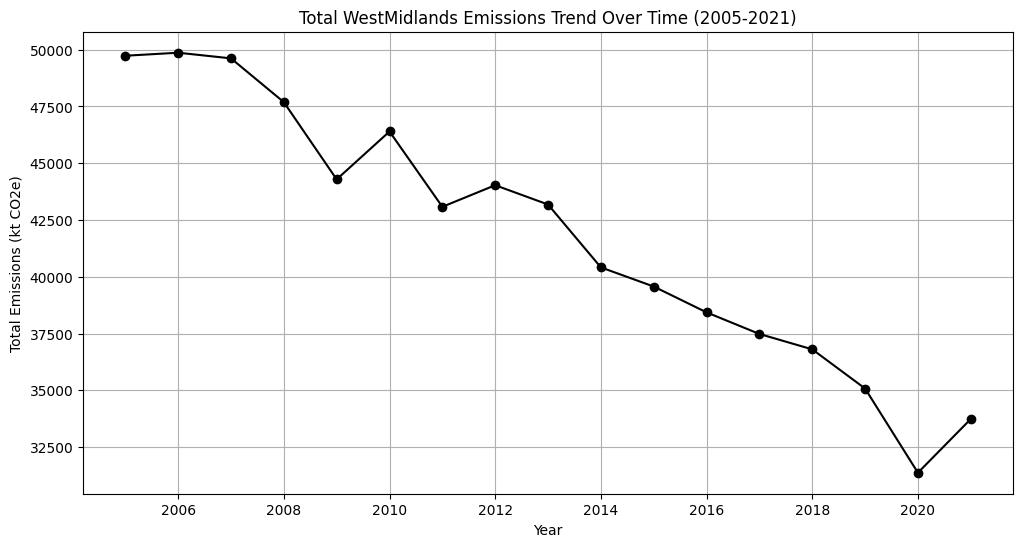

Calendar Year
2005    49732.222417
2006    49865.040184
2007    49616.825647
2008    47689.374420
2009    44287.997799
2010    46396.818960
2011    43080.033683
2012    44031.880064
2013    43181.893928
2014    40413.744458
2015    39570.616279
2016    38433.656517
2017    37482.255734
2018    36805.003905
2019    35080.103036
2020    31372.640144
2021    33736.855308
Name: Grand Total, dtype: float64

In [ ]:
import matplotlib.pyplot as plt

# Group by 'Calendar Year' and sum the 'Grand Total' column to get total emissions for each year
yearly_emissions = data_1_1_cleaned.groupby('Calendar Year')['Grand Total'].sum()

yearly_emissions_ = pd.DataFrame(yearly_emissions)

# Plotting the trend over time
plt.figure(figsize=(12, 6))
yearly_emissions.plot(marker='o', linestyle='-', color='black')
plt.title('Total WestMidlands Emissions Trend Over Time (2005-2021)')
plt.xlabel('Year')
plt.ylabel('Total Emissions (kt CO2e)')
plt.grid(True)
plt.show()
yearly_emissions

In [ ]:
from statsmodels.tsa.stattools import adfuller

#Augmented Dickey-Fuller test is used to test for the stationarity of a time series
adf_test = adfuller(yearly_emissions_['Grand Total'])
adf_test_output = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

In [ ]:
# Adding critical values
for key, value in adf_test[4].items():
    adf_test_output[f'Critical Value ({key})'] = value

In [ ]:
adf_test_output

Test Statistic                  1.644176
p-value                         0.997984
#Lags Used                      6.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64

p-value = 0.997984
Given the p-value is larger than 0.05, it suggest non-stationary data hence an attempt to difference the data

because p-value is greater than 0.05 this indicated that its non-stationary hence differencing is required

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Differencing the data to make it stationary
df_diff = yearly_emissions_['Grand Total'].diff().dropna()

adf_test_diff = adfuller(df_diff)
adf_test_diff_output = pd.Series(adf_test_diff[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

adf_test_diff_output

Test Statistic                 -5.102136
p-value                         0.000014
#Lags Used                      1.000000
Number of Observations Used    14.000000
dtype: float64

Now p-value 0.000014 is acceptable.
That suggest (d=1)

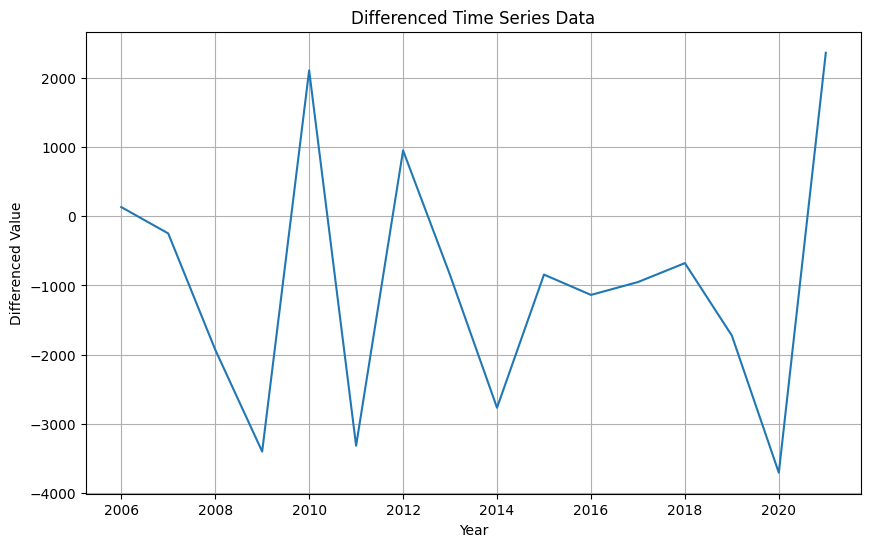

In [ ]:
# Plotting the differenced data
plt.figure(figsize=(10, 6))
plt.plot(df_diff)
plt.title('Differenced Time Series Data')
plt.xlabel('Year')
plt.ylabel('Differenced Value')
plt.grid(True)
plt.show()

For the AR and MA(p and q)

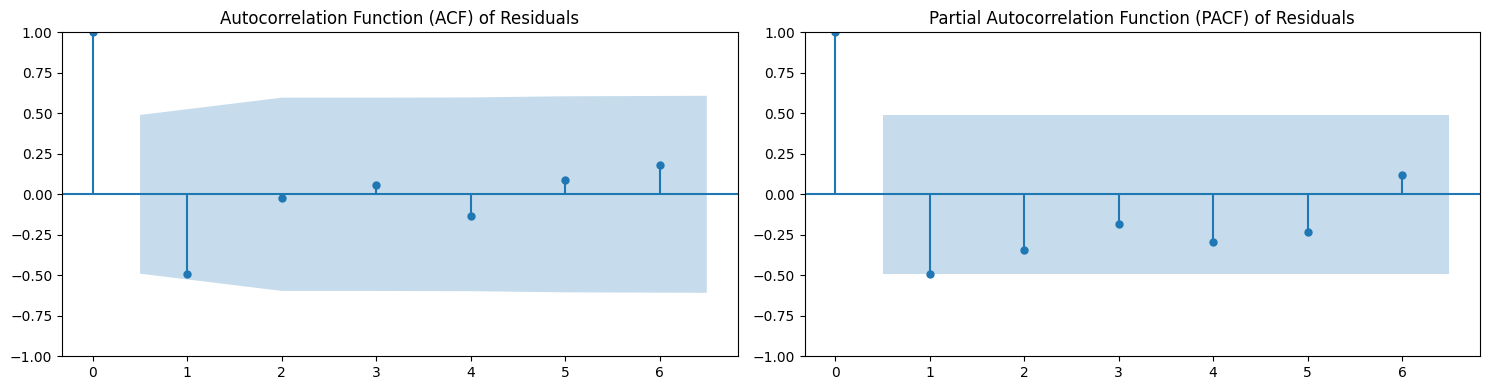

In [ ]:
 #ACF and PACF of residuals with fewer lags
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# ACF plot
plot_acf(df_diff, ax=ax[0], lags=6)
ax[0].set_title('Autocorrelation Function (ACF) of Residuals')

# PACF plot
plot_pacf(df_diff, ax=ax[1], lags=6)
ax[1].set_title('Partial Autocorrelation Function (PACF) of Residuals')

plt.tight_layout()
plt.show()


Differencing happen once (d=1), Picking p = 1 and q = 1 from the above plot

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Filter out the specific warning message
warnings.simplefilter("ignore", category=Warning)


# Fitting the ARIMA model with the determined parameters (p=1, d=1, q=1)
model = ARIMA(yearly_emissions_['Grand Total'], order=(1, 1, 1))
model_fit = model.fit()

# Summarizing the model output
model_summary = model_fit.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Grand Total   No. Observations:                   17
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -142.429
Date:                Sat, 10 Feb 2024   AIC                            290.858
Time:                        06:17:56   BIC                            293.175
Sample:                             0   HQIC                           290.976
                                 - 17                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9270      0.047     19.674      0.000       0.835       1.019
ma.L1         -0.9999      0.460     -2.174      0.030      -1.902      -0.098
sigma2      3.132e+06   1.47e-07   2.14e+13      0.000    3.13e+06    3.13e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.15   Jarque-Bera (JB):                 0.47
Prob(Q):                              0.08   Prob(JB):                         0.79
Heteroskedasticity (H):               1.06   Skew:                             0.15
Prob(H) (two-sided):                  0.95   Kurtosis:                         2.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.19e+28. Standard errors may be unstable.
"""

In [ ]:
# Forecasting future values using the ARIMA(1,1,1) model
forecast_periods = 5  # forecasting for next 5 years

# Forecasting future values
forecast = model_fit.forecast(steps=forecast_periods)
print(forecast)


17    33459.620002
18    33202.613189
19    32964.358894
20    32743.488839
21    32538.734582
Name: predicted_mean, dtype: float64


In [ ]:
# iterating over the ARIMA model
fitted_values = model_fit.predict(start=1, end=len(yearly_emissions_['Grand Total']))

# Printing the fitted values
print(fitted_values)


1     48344.756406
2     48521.854537
3     48329.290745
4     46521.264575
5     43296.417748
6     45347.749297
7     42204.603475
8     43140.477064
9     42353.687898
10    39733.880016
11    38947.878181
12    37880.404265
13    36988.257415
14    36355.859160
15    34725.826942
16    31209.360027
17    33459.620002
Name: predicted_mean, dtype: float64


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Actual values from 2006 to 2021
actual_values = [49865.040184, 49616.825647, 47689.374420, 44287.997799, 46396.818960,
                 43080.033683, 44031.880064, 43181.893928, 40413.744458, 39570.616279,
                 38433.656517, 37482.255734, 36805.003905, 35080.103036, 31372.640144,
                 33736.855308]

# Fitted values from your model for the same years
fitted_values = [48344.756378, 48521.854516, 48329.290731, 46521.264576, 43296.417769,
                 45347.749311, 42204.603509, 43140.477094, 42353.687935, 39733.880070,
                 38947.878241, 37880.404331, 36988.257487, 36355.859235, 34725.827027,
                 31209.360134]

mse = mean_squared_error(actual_values, fitted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_values, fitted_values)
r2 = r2_score(actual_values, fitted_values)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R2 Score:", r2)


MSE: 3156817.9134824006
RMSE: 1776.7436262675606
MAE: 1442.5323537499994
R2 Score: 0.8933601637161586


<h1>Calibrating Arima Model</h1>

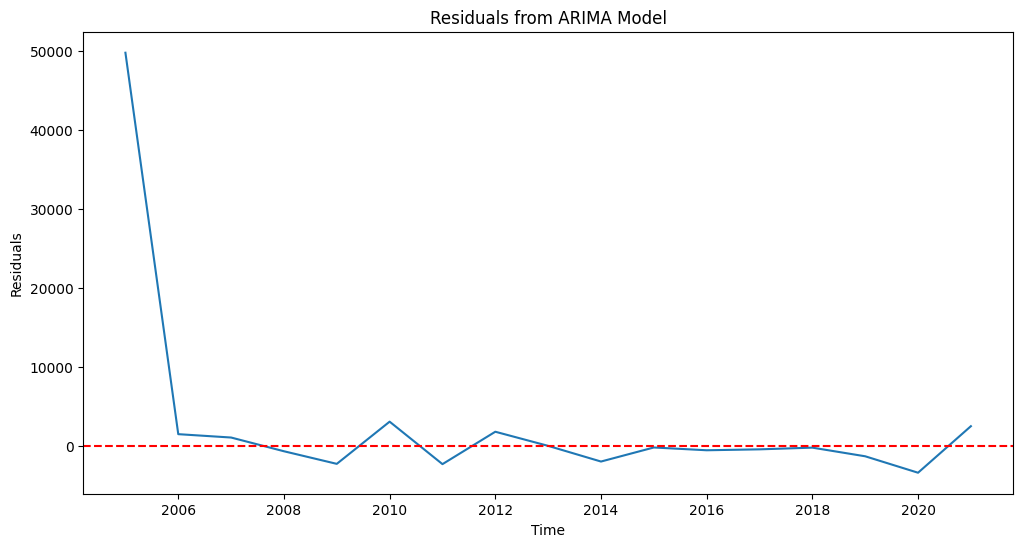

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(model_fit.resid)
plt.title('Residuals from ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


<Figure size 1000x500 with 0 Axes>

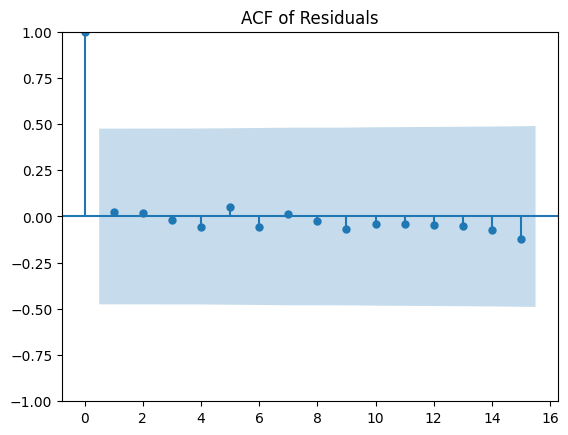

In [ ]:
plt.figure(figsize=(10, 5))
plot_acf(model_fit.resid, lags=15)
plt.title('ACF of Residuals')
plt.show()


In [ ]:
pip install statsmodels


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung_box_result = acorr_ljungbox(model_fit.resid, lags=[6], return_df=True)
print(ljung_box_result)


    lb_stat  lb_pvalue
6  0.285502   0.999564


<h1>LSTM</h1>

In [ ]:
# 1. Data Preparation
import pandas as pd

url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1166194/2005-21-uk-local-authority-ghg-emissions.xlsx'
data_1_1_cleaned = pd.read_excel(url, sheet_name='1_1', skiprows=4)

In [ ]:
# Filter the data for the "West Midlands" Region/Country
data_1_1_cleaned = data_1_1_cleaned[data_1_1_cleaned['Region/Country'] == 'West Midlands']
# Filter out rows where "Second Tier Authority" ends with "Total"
data_1_1_cleaned = data_1_1_cleaned[~data_1_1_cleaned['Second Tier Authority'].str.endswith("Total")]

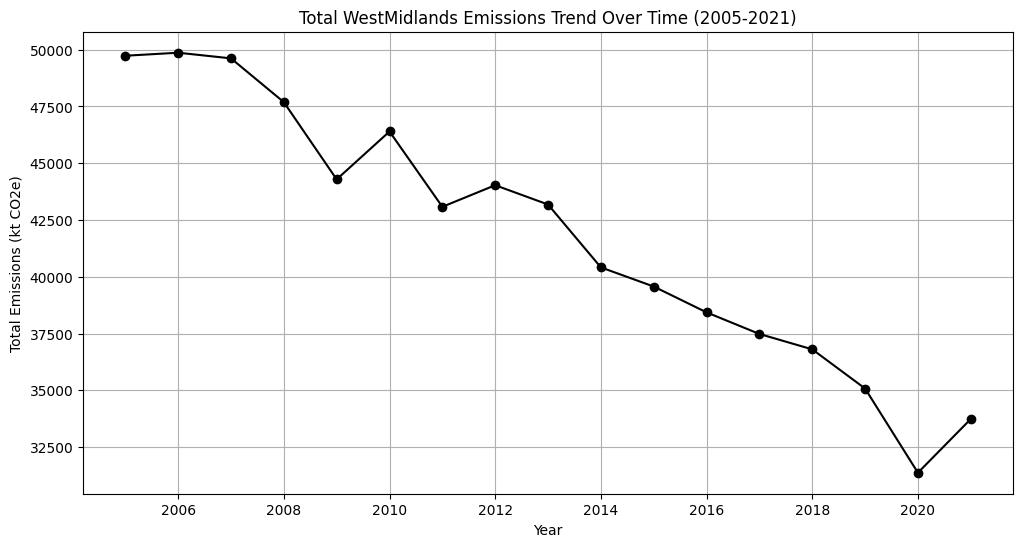

Calendar Year
2005    49732.222417
2006    49865.040184
2007    49616.825647
2008    47689.374420
2009    44287.997799
2010    46396.818960
2011    43080.033683
2012    44031.880064
2013    43181.893928
2014    40413.744458
2015    39570.616279
2016    38433.656517
2017    37482.255734
2018    36805.003905
2019    35080.103036
2020    31372.640144
2021    33736.855308
Name: Grand Total, dtype: float64

In [ ]:
import matplotlib.pyplot as plt

# Group by 'Calendar Year' and sum the 'Grand Total' column to get total emissions for each year
yearly_emissions = data_1_1_cleaned.groupby('Calendar Year')['Grand Total'].sum()

yearly_emissions_ = pd.DataFrame(yearly_emissions)

# Plotting the trend over time
plt.figure(figsize=(12, 6))
yearly_emissions.plot(marker='o', linestyle='-', color='black')
plt.title('Total WestMidlands Emissions Trend Over Time (2005-2021)')
plt.xlabel('Year')
plt.ylabel('Total Emissions (kt CO2e)')
plt.grid(True)
plt.show()
yearly_emissions

In [ ]:
pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Convert the Series to a DataFrame
yearly_emissions_df = yearly_emissions.to_frame()

# Normalize the dataset using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_emissions = scaler.fit_transform(yearly_emissions_df)

# Spliting the data into training and testing sets
train_size = int(len(scaled_emissions) * 0.67)
test_size = len(scaled_emissions) - train_size
train, test = scaled_emissions[0:train_size,:], scaled_emissions[train_size:len(scaled_emissions),:]

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#def create_dataset(dataset, look_back=1):
#    dataX, dataY = [], []
#    for i in range(len(dataset)-look_back):
#        a = dataset[i:(i+look_back), 0]
#        dataX.append(a)
#        dataY.append(dataset[i + look_back, 0])
#    return np.array(dataX), np.array(dataY)

#def create_dataset(dataset, look_back=1):
#    dataX, dataY = [], []
#    for i in range(len(dataset)-look_back):
#        a = dataset[i:(i+look_back), 0]
#        dataX.append(a)
#        dataY.append(dataset[i + look_back])
#    return np.array(dataX), np.array(dataY)



# Reshape the data into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2, validation_data=(testX, testY))

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions to original scale
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
#trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
#testY = scaler.inverse_transform(testY)

#testY = testY.reshape(-1, 1)  # Reshape testY to 2D
#testY = scaler.inverse_transform(testY)

# Calculate root mean squared error
trainScore = np.sqrt(np.mean((trainPredict[:,0] - trainY[0]) ** 2))
testScore = np.sqrt(np.mean((testPredict[:,0] - testY[0]) ** 2))

print('Train Score: %.2f RMSE' % trainScore)
print('Test Score: %.2f RMSE' % testScore)

Epoch 1/100
9/9 - 4s - loss: 0.4849 - val_loss: 0.0396 - 4s/epoch - 399ms/step
Epoch 2/100
9/9 - 0s - loss: 0.4631 - val_loss: 0.0353 - 74ms/epoch - 8ms/step
Epoch 3/100
9/9 - 0s - loss: 0.4405 - val_loss: 0.0313 - 86ms/epoch - 10ms/step
Epoch 4/100
9/9 - 0s - loss: 0.4196 - val_loss: 0.0276 - 81ms/epoch - 9ms/step
Epoch 5/100
9/9 - 0s - loss: 0.3976 - val_loss: 0.0243 - 95ms/epoch - 11ms/step
Epoch 6/100
9/9 - 0s - loss: 0.3764 - val_loss: 0.0214 - 103ms/epoch - 11ms/step
Epoch 7/100
9/9 - 0s - loss: 0.3553 - val_loss: 0.0189 - 87ms/epoch - 10ms/step
Epoch 8/100
9/9 - 0s - loss: 0.3333 - val_loss: 0.0169 - 88ms/epoch - 10ms/step
Epoch 9/100
9/9 - 0s - loss: 0.3134 - val_loss: 0.0153 - 87ms/epoch - 10ms/step
Epoch 10/100
9/9 - 0s - loss: 0.2922 - val_loss: 0.0142 - 82ms/epoch - 9ms/step
Epoch 11/100
9/9 - 0s - loss: 0.2711 - val_loss: 0.0137 - 94ms/epoch - 10ms/step
Epoch 12/100
9/9 - 0s - loss: 0.2522 - val_loss: 0.0136 - 182ms/epoch - 20ms/step
Epoch 13/100
9/9 - 0s - loss: 0.2333 - 

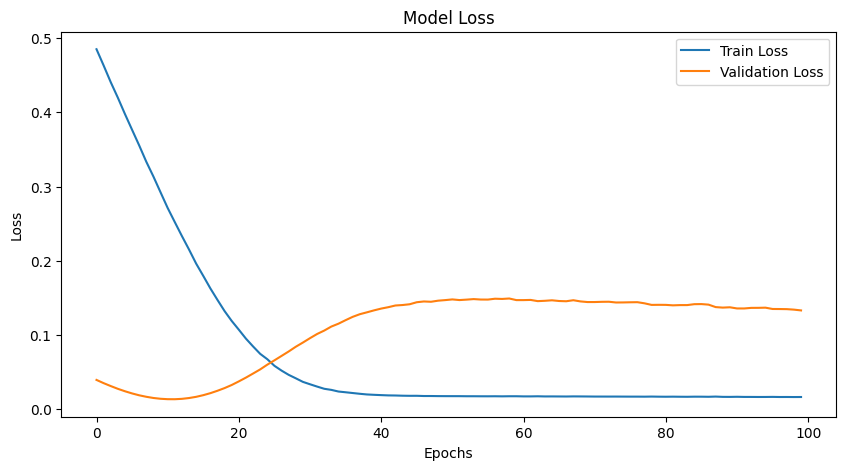

In [ ]:
# Plot the training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')

plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

<H1>Regression Analysis</H1>



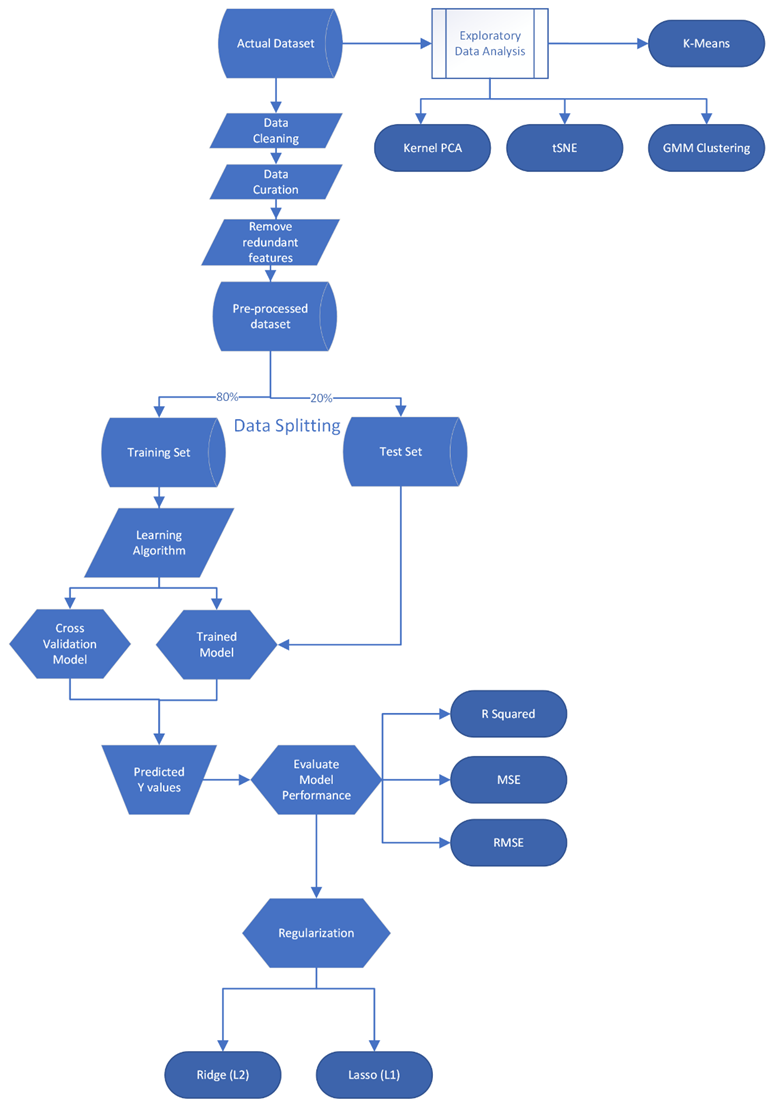

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler




In [ ]:
# Load the first few rows from the '1_1' sheet to explore its contents

url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1166194/2005-21-uk-local-authority-ghg-emissions.xlsx'
data_1_1 = pd.read_excel(url, sheet_name='1_1')

#data_1_1 = pd.read_excel("2005-21-uk-local-authority-ghg-emissions-update-060723.xlsx", sheet_name='1_1')
data_1_1.head()

Table 1.1: Local Authority territorial greenhouse gas emissions estimates 2005-2021 (kt CO2e) - Full dataset  \
0  This worksheet contains one table. The table c...                                                             
1  Freeze panes are active on this sheet. To turn...                                                             
2  Filters are active in cells A5 to AX5 and may ...                                                             
3                                     Region/Country                                                             
4                                         North East                                                             

              Unnamed: 1       Unnamed: 2            Unnamed: 3  \
0                    NaN              NaN                   NaN   
1                    NaN              NaN                   NaN   
2                    NaN              NaN                   NaN   
3  Second Tier Authority  Local Authority  Local Authority Code   
4             Darlington       Darlington             E06000005   

      Unnamed: 4            Unnamed: 5     Unnamed: 6  \
0            NaN                   NaN            NaN   
1            NaN                   NaN            NaN   
2            NaN                   NaN            NaN   
3  Calendar Year  Industry Electricity  Industry Gas    
4           2005              51.87311     114.701874   

                       Unnamed: 7        Unnamed: 8      Unnamed: 9  ...  \
0                             NaN               NaN             NaN  ...   
1                             NaN               NaN             NaN  ...   
2                             NaN               NaN             NaN  ...   
3  Large Industrial Installations  Industry 'Other'  Industry Total  ...   
4                        0.045681         43.073543      209.694209  ...   

         Unnamed: 40        Unnamed: 41 Unnamed: 42               Unnamed: 43  \
0                NaN                NaN         NaN                       NaN   
1                NaN                NaN         NaN                       NaN   
2                NaN                NaN         NaN                       NaN   
3  Agriculture Soils  Agriculture Total    Landfill  Waste Management 'Other'   
4          12.699185            63.7069   34.256022                  5.613394   

              Unnamed: 44  Unnamed: 45                            Unnamed: 46  \
0                     NaN          NaN                                    NaN   
1                     NaN          NaN                                    NaN   
2                     NaN          NaN                                    NaN   
3  Waste Management Total  Grand Total  Population ('000s, mid-year estimate)   
4               39.869415   968.661604                                100.287   

                    Unnamed: 47 Unnamed: 48                  Unnamed: 49  
0                           NaN         NaN                          NaN  
1                           NaN         NaN                          NaN  
2                           NaN         NaN                          NaN  
3  Per Capita Emissions (tCO2e)  Area (km2)  Emissions per km2 (kt CO2e)  
4                      9.658895    197.4758                     4.905217  

[5 rows x 50 columns]

In [ ]:
# Extract the actual data, excluding the header information
data_1_1_actual = data_1_1.iloc[4:]

# Set the column names from the header row
data_1_1_actual.columns = data_1_1.iloc[3]


# Reset the index for the actual data
data_1_1_actual = data_1_1_actual.reset_index(drop=True)

# Convert the 'Grand Total' column to a numeric type
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_numeric.html
data_1_1_actual['Grand Total'] = pd.to_numeric(data_1_1_actual['Grand Total'], errors='coerce')

# Filter the data for the "West Midlands" Region/Country
west_midlands_data = data_1_1_actual[data_1_1_actual['Region/Country'] == 'West Midlands']

# Filter out rows where "Second Tier Authority" ends with "Total"
west_midlands_data_filtered = west_midlands_data[~west_midlands_data['Second Tier Authority'].str.endswith("Total")]

# List of columns to keep
columns_to_keep = ['Region/Country', 'Second Tier Authority', 'Local Authority', 'Local Authority Code', 'Calendar Year', 'LULUCF Net Emissions']

# Add columns that end with "Total"
columns_to_keep.extend([col for col in west_midlands_data_filtered.columns if col.endswith("Total")])
west_midlands_filtered_columns = west_midlands_data_filtered[columns_to_keep]

In [ ]:
# Create the pivot table of west_midlands local authorities emission
west_midlands_local_authority_emissions = pd.pivot_table(west_midlands_filtered_columns, values='Grand Total', index=['Local Authority'], columns=['Calendar Year'])

west_midlands_local_authority_emissions.to_csv('west_midlands_filtered_columns_by_year.csv')
west_midlands_local_authority_emissions

Calendar Year                    2005         2006         2007         2008  \
Local Authority                                                                
Birmingham                7059.334372  6952.112034  6800.522322  6744.677640   
Bromsgrove                 956.642291   966.027098  1014.325992   966.508457   
Cannock Chase              588.979929   597.874966   584.212829   554.965633   
Coventry                  2285.257172  2244.459643  2109.501041  2028.053404   
Dudley                    1983.590348  1972.154700  1888.505634  1818.345968   
East Staffordshire        1287.270750  1298.775799  1260.546128  1245.328814   
Herefordshire, County of  2091.684474  2090.207781  2038.853224  1975.986634   
Lichfield                 1004.513597  1022.789515  1013.242837   993.374843   
Malvern Hills              772.773159   799.621230   848.442583   797.397569   
Newcastle-under-Lyme      1121.822896  1113.654899  1107.267011  1087.895669   
North Warwickshire        1147.478903  1203.041332  1226.193958  1194.492043   
Nuneaton and Bedworth      813.097075   815.719471   861.239859   828.813779   
Redditch                   585.906245   591.548822   632.697674   593.920918   
Rugby                     2330.213067  2373.288078  2651.893434  2411.372020   
Sandwell                  2289.664199  2311.288395  2271.410144  2149.609456   
Shropshire                3788.039158  3772.811560  3701.754274  3605.369762   
Solihull                  1735.803608  1801.630633  1757.701820  1667.849693   
South Staffordshire       1142.941882  1174.670664  1167.283617  1104.231784   
Stafford                  1593.609395  1616.541260  1569.472252  1566.564484   
Staffordshire Moorlands   1776.923545  1766.082186  1742.557987  1656.608649   
Stoke-on-Trent            2041.728131  2025.362057  1977.856972  1900.940420   
Stratford-on-Avon         1501.480094  1513.735452  1541.393414  1488.757386   
Tamworth                   475.068557   474.697517   448.760723   436.457918   
Telford and Wrekin        1659.122170  1685.979582  1682.256128  1530.383297   
Walsall                   1841.638129  1829.666727  1772.033335  1673.938533   
Warwick                   1391.720595  1400.843990  1409.130871  1362.768363   
Wolverhampton             1677.179103  1629.700831  1587.437458  1536.582527   
Worcester                  643.542399   616.473972   657.726991   608.166828   
Wychavon                  1447.518551  1504.532587  1542.140801  1467.778761   
Wyre Forest                697.678624   699.747403   750.464334   692.233167   

Calendar Year                    2009         2010         2011         2012  \
Local Authority                                                                
Birmingham                6099.737055  6412.804284  5805.907414  6094.847957   
Bromsgrove                 915.239428   943.043254   865.875640   885.439318   
Cannock Chase              534.431424   565.871617   516.643905   523.651492   
Coventry                  1835.162506  1962.611578  1766.002096  1881.254900   
Dudley                    1657.763334  1778.665829  1603.028674  1645.915361   
East Staffordshire        1170.588639  1228.732489  1160.773439  1165.877455   
Herefordshire, County of  1872.500149  1994.484316  1849.438619  1892.331768   
Lichfield                  955.231477   981.016859   931.692962   938.137617   
Malvern Hills              757.938462   782.645008   723.285139   726.094378   
Newcastle-under-Lyme      1042.573930  1083.119199  1024.749999  1024.635624   
North Warwickshire        1121.940224  1191.290419  1085.180037  1110.955808   
Nuneaton and Bedworth      772.443801   765.017013   677.858160   704.027486   
Redditch                   533.689582   577.553981   522.724477   528.282173   
Rugby                     2278.320929  2283.729045  2334.076177  2124.141199   
Sandwell                  1915.683984  2035.995284  1862.670040  1942.089900   
Shropshire                3330.136985  3537.762726  3277.426402  3379.256702   

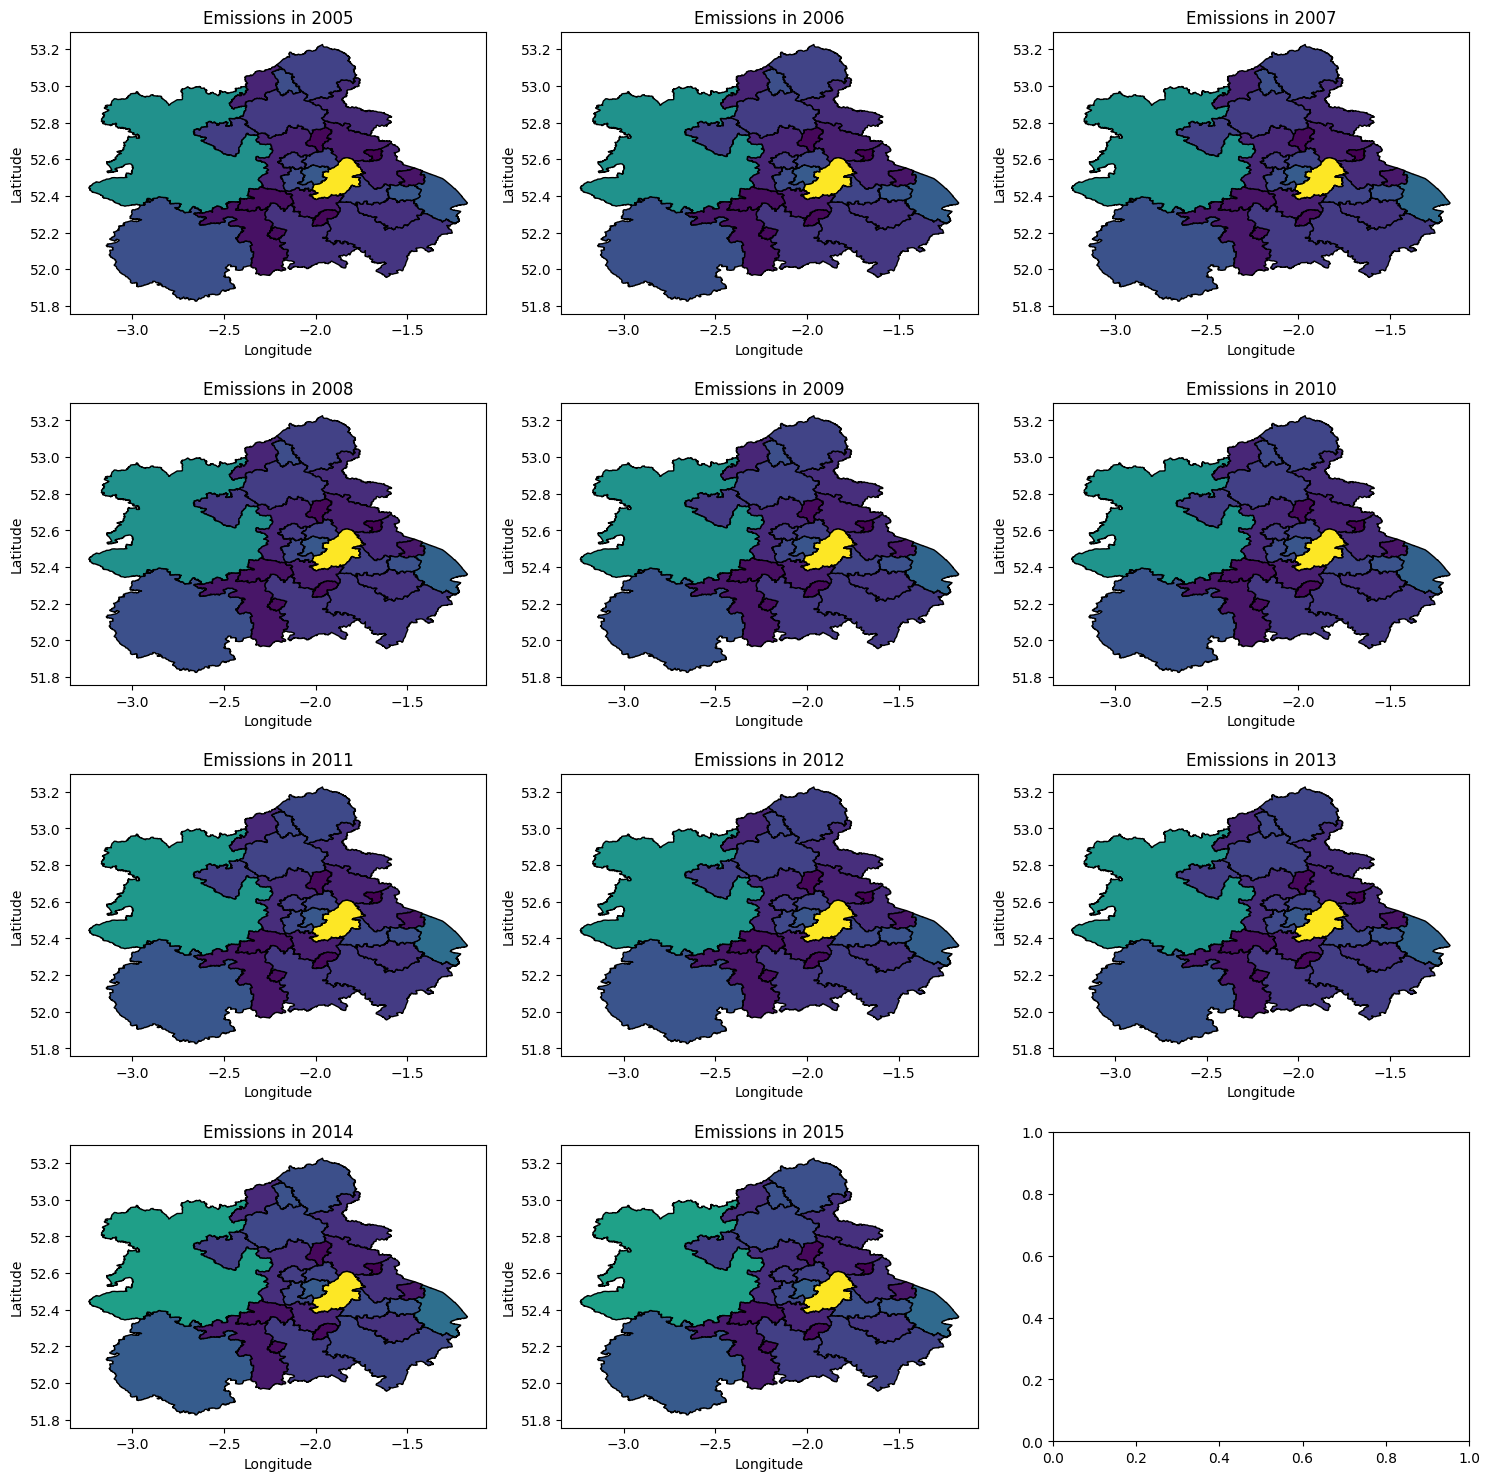

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Read the emissions data from a CSV file
emissions_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/west_midlands_filtered_columns_by_year.csv'
emissions_df = pd.read_csv(emissions_csv_path, index_col='Local Authority')

# Read the GeoDataFrame from a CSV file containing geometries
topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv'
topo_lad_df = pd.read_csv(topo_lad_csv_path)

# Convert the DataFrame to a GeoDataFrame
topo_lad_gdf = gpd.GeoDataFrame(topo_lad_df, geometry=gpd.GeoSeries.from_wkt(topo_lad_df['geometry']))

# Set the figure size for the plots
fig, axs = plt.subplots(4, 3, figsize=(15, 15))
axs = axs.flatten()

# Iterate over the range of years and create a plot for each
for idx, year in enumerate(range(2005, 2016)):
    # Select the column for the year
    year_column = str(year)
    westmidlands_emissions_df = emissions_df[[year_column]]

    # Merge the emissions data with the GeoDataFrame
    filtered_gdf = topo_lad_gdf.merge(westmidlands_emissions_df, left_on='LAD13NM', right_index=True)

    # Plot the merged data with "Emissions" as the color indicator
    ax = axs[idx]
    filtered_gdf.plot(ax=ax, column=year_column, cmap='viridis', legend=False, edgecolor='black')

    # Annotate each region with its name for clarity
    #for row_idx, row in filtered_gdf.iterrows():
    #    ax.annotate(text=row['LAD13NM'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
    #                xytext=(3, 3), textcoords='offset points', ha='center', fontsize=6)

    # Set the title for each subplot
    ax.set_title(f'Emissions in {year}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_aspect('equal')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Calculate the yearly total emissions for each year
yearly_totals = west_midlands_local_authority_emissions.sum()

# Append the totals as a new row to the DataFrame
west_midlands_local_authority_emissions.loc['Total'] = yearly_totals

west_midlands_local_authority_emissions

Calendar Year                     2005          2006          2007  \
Local Authority                                                      
Birmingham                 7059.334372   6952.112034   6800.522322   
Bromsgrove                  956.642291    966.027098   1014.325992   
Cannock Chase               588.979929    597.874966    584.212829   
Coventry                   2285.257172   2244.459643   2109.501041   
Dudley                     1983.590348   1972.154700   1888.505634   
East Staffordshire         1287.270750   1298.775799   1260.546128   
Herefordshire, County of   2091.684474   2090.207781   2038.853224   
Lichfield                  1004.513597   1022.789515   1013.242837   
Malvern Hills               772.773159    799.621230    848.442583   
Newcastle-under-Lyme       1121.822896   1113.654899   1107.267011   
North Warwickshire         1147.478903   1203.041332   1226.193958   
Nuneaton and Bedworth       813.097075    815.719471    861.239859   
Redditch                    585.906245    591.548822    632.697674   
Rugby                      2330.213067   2373.288078   2651.893434   
Sandwell                   2289.664199   2311.288395   2271.410144   
Shropshire                 3788.039158   3772.811560   3701.754274   
Solihull                   1735.803608   1801.630633   1757.701820   
South Staffordshire        1142.941882   1174.670664   1167.283617   
Stafford                   1593.609395   1616.541260   1569.472252   
Staffordshire Moorlands    1776.923545   1766.082186   1742.557987   
Stoke-on-Trent             2041.728131   2025.362057   1977.856972   
Stratford-on-Avon          1501.480094   1513.735452   1541.393414   
Tamworth                    475.068557    474.697517    448.760723   
Telford and Wrekin         1659.122170   1685.979582   1682.256128   
Walsall                    1841.638129   1829.666727   1772.033335   
Warwick                    1391.720595   1400.843990   1409.130871   
Wolverhampton              1677.179103   1629.700831   1587.437458   
Worcester                   643.542399    616.473972    657.726991   
Wychavon                   1447.518551   1504.532587   1542.140801   
Wyre Forest                 697.678624    699.747403    750.464334   
Total                     49732.222417  49865.040184  49616.825647   

Calendar Year                     2008          2009          2010  \
Local Authority                                                      
Birmingham                 6744.677640   6099.737055   6412.804284   
Bromsgrove                  966.508457    915.239428    943.043254   
Cannock Chase               554.965633    534.431424    565.871617   
Coventry                   2028.053404   1835.162506   1962.611578   
Dudley                     1818.345968   1657.763334   1778.665829   
East Staffordshire         1245.328814   1170.588639   1228.732489   
Herefordshire, County of   1975.986634   1872.500149   1994.484316   
Lichfield                   993.374843    955.231477    981.016859   
Malvern Hills               797.397569    757.938462    782.645008   
Newcastle-under-Lyme       1087.895669   1042.573930   1083.119199   
North Warwickshire         1194.492043   1121.940224   1191.290419   
Nuneaton and Bedworth       828.813779    772.443801    765.017013   
Redditch                    593.920918    533.689582    577.553981   
Rugby                      2411.372020   2278.320929   2283.729045   
Sandwell                   2149.609456   1915.683984   2035.995284   
Shropshire                 3605.369762   3330.136985   3537.762726   
Solihull                   1667.849693   1565.457992   1683.199281   
South Staffordshire        1104.231784   1101.010671   1130.681369   
Stafford                   1566.564484   1533.426323   1571.727852   
Staffordshire Moorlands    1656.608649   1559.741550   1655.713572   
Stoke-on-Trent             1900.940420   1777.333094   1764.352853   
Stratford-on-Avon          1488.757386   1386.832211   1436.903217   
Tamworth 

In [ ]:
import matplotlib.pyplot as plt

west_midlands_local_authority_emissions.loc['Total'] = yearly_totals

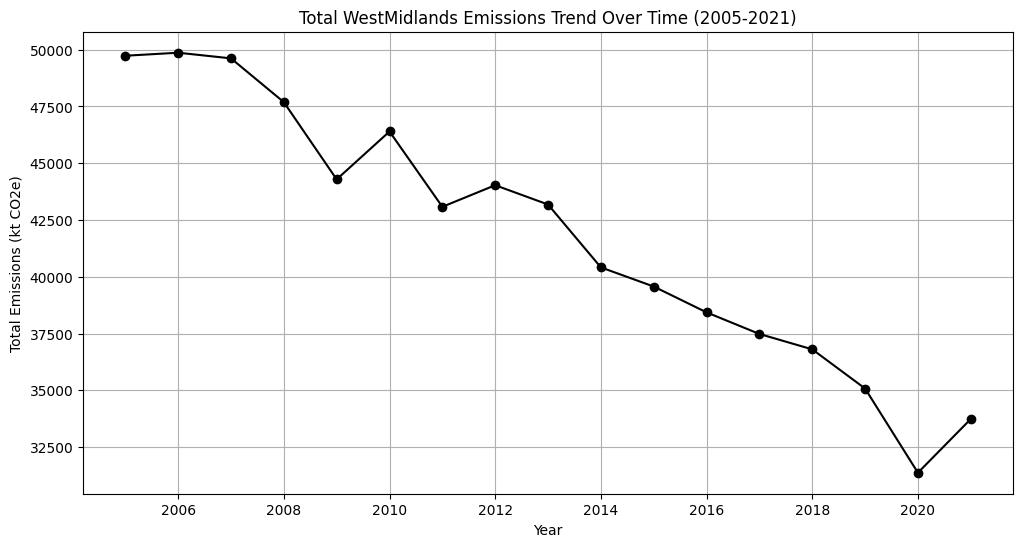

Calendar Year
2005    49732.222417
2006    49865.040184
2007    49616.825647
2008    47689.374420
2009    44287.997799
2010    46396.818960
2011    43080.033683
2012    44031.880064
2013    43181.893928
2014    40413.744458
2015    39570.616279
2016    38433.656517
2017    37482.255734
2018    36805.003905
2019    35080.103036
2020    31372.640144
2021    33736.855308
dtype: float64

In [ ]:
# Plotting the trend over time
plt.figure(figsize=(12, 6))
yearly_totals.plot(marker='o', linestyle='-', color='black')
plt.title('Total WestMidlands Emissions Trend Over Time (2005-2021)')
plt.xlabel('Year')
plt.ylabel('Total Emissions (kt CO2e)')
plt.grid(True)
plt.show()
yearly_totals

In [ ]:
data_transposed = west_midlands_local_authority_emissions
data_transposed.to_csv('west_midlands_local_authority_emissions.csv')
data_transposed

Calendar Year                     2005          2006          2007  \
Local Authority                                                      
Birmingham                 7059.334372   6952.112034   6800.522322   
Bromsgrove                  956.642291    966.027098   1014.325992   
Cannock Chase               588.979929    597.874966    584.212829   
Coventry                   2285.257172   2244.459643   2109.501041   
Dudley                     1983.590348   1972.154700   1888.505634   
East Staffordshire         1287.270750   1298.775799   1260.546128   
Herefordshire, County of   2091.684474   2090.207781   2038.853224   
Lichfield                  1004.513597   1022.789515   1013.242837   
Malvern Hills               772.773159    799.621230    848.442583   
Newcastle-under-Lyme       1121.822896   1113.654899   1107.267011   
North Warwickshire         1147.478903   1203.041332   1226.193958   
Nuneaton and Bedworth       813.097075    815.719471    861.239859   
Redditch                    585.906245    591.548822    632.697674   
Rugby                      2330.213067   2373.288078   2651.893434   
Sandwell                   2289.664199   2311.288395   2271.410144   
Shropshire                 3788.039158   3772.811560   3701.754274   
Solihull                   1735.803608   1801.630633   1757.701820   
South Staffordshire        1142.941882   1174.670664   1167.283617   
Stafford                   1593.609395   1616.541260   1569.472252   
Staffordshire Moorlands    1776.923545   1766.082186   1742.557987   
Stoke-on-Trent             2041.728131   2025.362057   1977.856972   
Stratford-on-Avon          1501.480094   1513.735452   1541.393414   
Tamworth                    475.068557    474.697517    448.760723   
Telford and Wrekin         1659.122170   1685.979582   1682.256128   
Walsall                    1841.638129   1829.666727   1772.033335   
Warwick                    1391.720595   1400.843990   1409.130871   
Wolverhampton              1677.179103   1629.700831   1587.437458   
Worcester                   643.542399    616.473972    657.726991   
Wychavon                   1447.518551   1504.532587   1542.140801   
Wyre Forest                 697.678624    699.747403    750.464334   
Total                     49732.222417  49865.040184  49616.825647   

Calendar Year                     2008          2009          2010  \
Local Authority                                                      
Birmingham                 6744.677640   6099.737055   6412.804284   
Bromsgrove                  966.508457    915.239428    943.043254   
Cannock Chase               554.965633    534.431424    565.871617   
Coventry                   2028.053404   1835.162506   1962.611578   
Dudley                     1818.345968   1657.763334   1778.665829   
East Staffordshire         1245.328814   1170.588639   1228.732489   
Herefordshire, County of   1975.986634   1872.500149   1994.484316   
Lichfield                   993.374843    955.231477    981.016859   
Malvern Hills               797.397569    757.938462    782.645008   
Newcastle-under-Lyme       1087.895669   1042.573930   1083.119199   
North Warwickshire         1194.492043   1121.940224   1191.290419   
Nuneaton and Bedworth       828.813779    772.443801    765.017013   
Redditch                    593.920918    533.689582    577.553981   
Rugby                      2411.372020   2278.320929   2283.729045   
Sandwell                   2149.609456   1915.683984   2035.995284   
Shropshire                 3605.369762   3330.136985   3537.762726   
Solihull                   1667.849693   1565.457992   1683.199281   
South Staffordshire        1104.231784   1101.010671   1130.681369   
Stafford                   1566.564484   1533.426323   1571.727852   
Staffordshire Moorlands    1656.608649   1559.741550   1655.713572   
Stoke-on-Trent             1900.940420   1777.333094   1764.352853   
Stratford-on-Avon          1488.757386   1386.832211   1436.903217   
Tamworth 

In [ ]:
X = data_transposed.loc[:, 2005:2020]
y = data_transposed[2021]

In [ ]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=10)


In [ ]:
# Train the model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Evaluate the model
print("Intercept:", regressor.intercept_)
print("Coefficients:", regressor.coef_)

# Predicting
y_pred = regressor.predict(X_test)

# Printing shapes of predictions and test labels
print(y_pred.shape, y_test.shape)

Intercept: 6.358880146775391
Coefficients: [-0.46276701  0.67328558  0.02979568 -0.1036658   0.22833449 -0.08693259
  0.27250066 -0.04820699 -0.75399125  0.09281595 -0.12834322  0.4178228
  0.71459305 -0.42653192 -0.53009634  1.15639934]
(7,) (7,)


In [ ]:
X

Calendar Year                     2005          2006          2007  \
Local Authority                                                      
Birmingham                 7059.334372   6952.112034   6800.522322   
Bromsgrove                  956.642291    966.027098   1014.325992   
Cannock Chase               588.979929    597.874966    584.212829   
Coventry                   2285.257172   2244.459643   2109.501041   
Dudley                     1983.590348   1972.154700   1888.505634   
East Staffordshire         1287.270750   1298.775799   1260.546128   
Herefordshire, County of   2091.684474   2090.207781   2038.853224   
Lichfield                  1004.513597   1022.789515   1013.242837   
Malvern Hills               772.773159    799.621230    848.442583   
Newcastle-under-Lyme       1121.822896   1113.654899   1107.267011   
North Warwickshire         1147.478903   1203.041332   1226.193958   
Nuneaton and Bedworth       813.097075    815.719471    861.239859   
Redditch                    585.906245    591.548822    632.697674   
Rugby                      2330.213067   2373.288078   2651.893434   
Sandwell                   2289.664199   2311.288395   2271.410144   
Shropshire                 3788.039158   3772.811560   3701.754274   
Solihull                   1735.803608   1801.630633   1757.701820   
South Staffordshire        1142.941882   1174.670664   1167.283617   
Stafford                   1593.609395   1616.541260   1569.472252   
Staffordshire Moorlands    1776.923545   1766.082186   1742.557987   
Stoke-on-Trent             2041.728131   2025.362057   1977.856972   
Stratford-on-Avon          1501.480094   1513.735452   1541.393414   
Tamworth                    475.068557    474.697517    448.760723   
Telford and Wrekin         1659.122170   1685.979582   1682.256128   
Walsall                    1841.638129   1829.666727   1772.033335   
Warwick                    1391.720595   1400.843990   1409.130871   
Wolverhampton              1677.179103   1629.700831   1587.437458   
Worcester                   643.542399    616.473972    657.726991   
Wychavon                   1447.518551   1504.532587   1542.140801   
Wyre Forest                 697.678624    699.747403    750.464334   
Total                     49732.222417  49865.040184  49616.825647   

Calendar Year                     2008          2009          2010  \
Local Authority                                                      
Birmingham                 6744.677640   6099.737055   6412.804284   
Bromsgrove                  966.508457    915.239428    943.043254   
Cannock Chase               554.965633    534.431424    565.871617   
Coventry                   2028.053404   1835.162506   1962.611578   
Dudley                     1818.345968   1657.763334   1778.665829   
East Staffordshire         1245.328814   1170.588639   1228.732489   
Herefordshire, County of   1975.986634   1872.500149   1994.484316   
Lichfield                   993.374843    955.231477    981.016859   
Malvern Hills               797.397569    757.938462    782.645008   
Newcastle-under-Lyme       1087.895669   1042.573930   1083.119199   
North Warwickshire         1194.492043   1121.940224   1191.290419   
Nuneaton and Bedworth       828.813779    772.443801    765.017013   
Redditch                    593.920918    533.689582    577.553981   
Rugby                      2411.372020   2278.320929   2283.729045   
Sandwell                   2149.609456   1915.683984   2035.995284   
Shropshire                 3605.369762   3330.136985   3537.762726   
Solihull                   1667.849693   1565.457992   1683.199281   
South Staffordshire        1104.231784   1101.010671   1130.681369   
Stafford                   1566.564484   1533.426323   1571.727852   
Staffordshire Moorlands    1656.608649   1559.741550   1655.713572   
Stoke-on-Trent             1900.940420   1777.333094   1764.352853   
Stratford-on-Avon          1488.757386   1386.832211   1436.903217   
Tamworth 

In [ ]:
y

Local Authority
Birmingham                   4480.654084
Bromsgrove                    711.760256
Cannock Chase                 364.042820
Coventry                     1344.000349
Dudley                       1163.033149
East Staffordshire            853.521292
Herefordshire, County of     1472.865799
Lichfield                     754.890754
Malvern Hills                 601.444378
Newcastle-under-Lyme          844.190037
North Warwickshire            919.630410
Nuneaton and Bedworth         540.854821
Redditch                      357.787785
Rugby                        2026.454350
Sandwell                     1401.088684
Shropshire                   2773.370585
Solihull                     1226.181599
South Staffordshire           954.939263
Stafford                     1166.734395
Staffordshire Moorlands      1332.991944
Stoke-on-Trent               1127.356084
Stratford-on-Avon            1120.139928
Tamworth                      268.838288
Telford and Wrekin           1002.876199


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

west_midlands_local_authority_emissions

X = west_midlands_local_authority_emissions.loc[:, 2005:2020]
y = west_midlands_local_authority_emissions[2021]

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=10)

# Train the model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Evaluate the model
print("Intercept:", regressor.intercept_)
print("Coefficients:", regressor.coef_)

#predicting the test set result
y_pred = regressor.predict(X_test)
print(y_pred.shape,y_test.shape)
y_pred,y_test

Intercept: 6.358880146775391
Coefficients: [-0.46276701  0.67328558  0.02979568 -0.1036658   0.22833449 -0.08693259
  0.27250066 -0.04820699 -0.75399125  0.09281595 -0.12834322  0.4178228
  0.71459305 -0.42653192 -0.53009634  1.15639934]
(7,) (7,)


(array([1232.85624046,  738.78645797,  880.00216811,  393.21771001,
        1375.03203259, 1101.11372555, 2054.79029596]),
 Local Authority
 Stoke-on-Trent        1127.356084
 Lichfield              754.890754
 East Staffordshire     853.521292
 Cannock Chase          364.042820
 Coventry              1344.000349
 Stratford-on-Avon     1120.139928
 Rugby                 2026.454350
 Name: 2021, dtype: float64)

<script type="text/javascript" src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML"></script>


<p>Based on the output from the linear regression model, an approximate prediction equation for the emissions in 2021 is formed. The equation is structured as follows, where Xi represents the emissions in year 2005 + i (for i = 0, 1, 2, ..., 15):

Emissions_2021 = Intercept + c1 * X0 + c2 * X1 + ... + c16 * X15


<h1>GRU</h1>

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [ ]:
#!cp "/content/drive/My Drive/Colab Notebooks/west_midlands_filtered_columns.csv" "west_midlands_filtered_columns.csv"

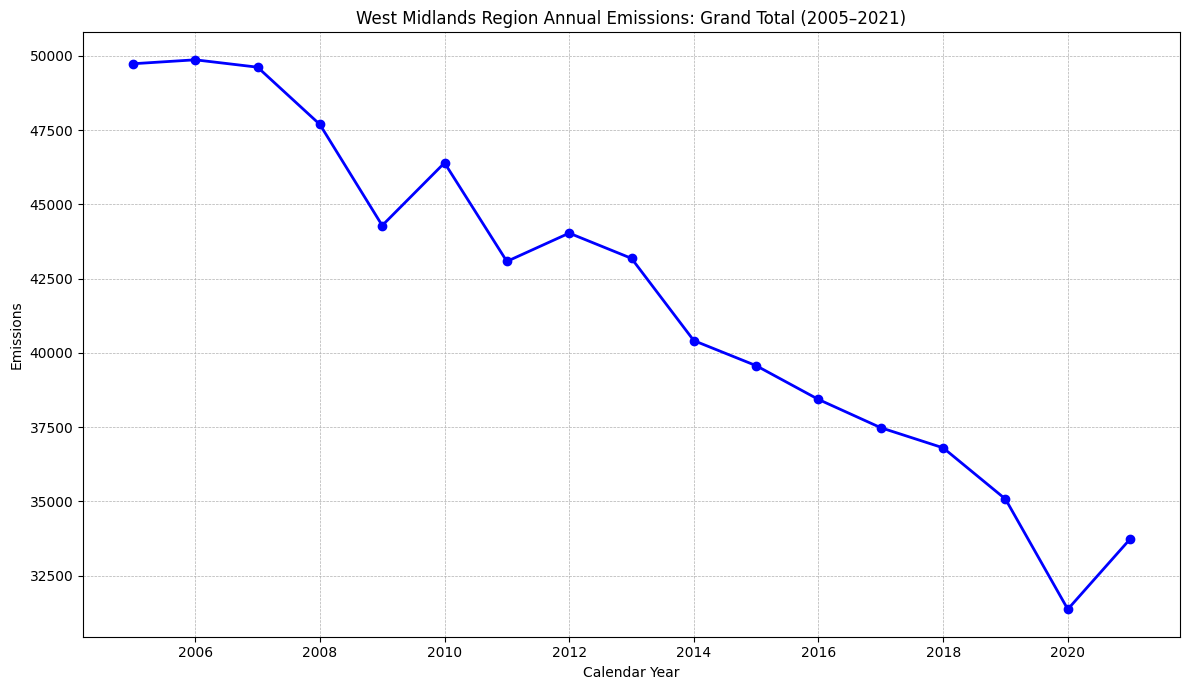

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Read the data
df = pd.read_csv('https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/west_midlands_filtered_columns.csv')

#df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/west_midlands_filtered_columns.csv')

#https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/west_midlands_filtered_columns.csv
# Group by 'Calendar Year' and sum the "Grand Total" values for each year
grouped_data = df.groupby('Calendar Year')['Grand Total'].sum()

# Plot the summed values for each year
plt.figure(figsize=(12, 7))
grouped_data.plot(kind='line', marker='o', color='blue', linewidth=2)

plt.title('West Midlands Region Annual Emissions: Grand Total (2005–2021)')
plt.ylabel('Emissions')
plt.xlabel('Calendar Year')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Modeling the time series data using a GRU. Proceeding with the following steps:

1. Data Preparation:
   - Normalize the data.
   - Transform the time series data into input-output pairs for supervised learning.
2. Define the GRU Model.
3. Compile and Train the Model.
4. Evaluate the Model.
5. Forecasting.

### Data Preparation

For this demonstration, a sliding window approach where the use of the emissions of the last \( N \) years to predict the emissions of the next year. Then setting \( N \) to 5.

Starting by normalizing the data and creating our input-output pairs.

The data has been prepared for training:

- Having 9 training samples and 3 testing samples.
- Each training sample has 1 time step and 5 features (i.e., the emissions of the last 5 years).
- The corresponding output is the emission of the next year.



### Define the GRU Model

A simple GRU-based model for this task. The model will consist of:

- An input layer that accepts sequences of 5 past observations.
- A GRU layer with 50 units.
- A dense output layer with a linear activation function to predict the next year's emissions.


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Define a function to convert time series data into input-output pairs
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(grouped_data.values.reshape(-1, 1))

# Convert time series data into input-output pairs
N = 5  # number of past observations to use for prediction
data = series_to_supervised(scaled_data, n_in=N, n_out=1)
values = data.values

# Split the data into training and testing sets
train_size = int(0.8 * len(values))
train, test = values[:train_size, :], values[train_size:, :]
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

# Reshaping data to 3D [samples, timesteps, features] for GRU
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

X_train.shape, y_train.shape, X_test.shape, y_test.shape


((9, 1, 5), (9,), (3, 1, 5), (3,))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Define the GRU model
model = Sequential()
model.add(GRU(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Display the model's architecture
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50)                8550      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 8601 (33.60 KB)
Trainable params: 8601 (33.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Predict on the test set
y_pred = model.predict(X_test)

1/1 [==============================] - 1s 730ms/step


In [ ]:
# Inverse transform the predictions to the original scale
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
print(f"Test RMSE: {rmse}")

Test RMSE: 2772.89834123591


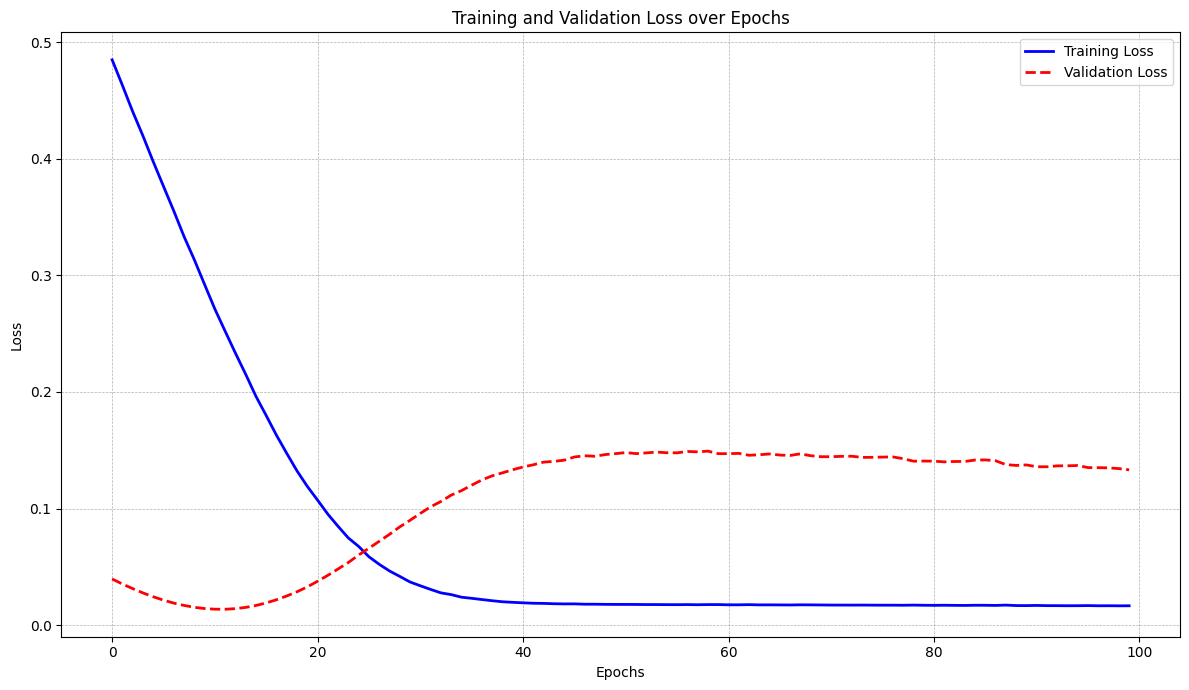

In [ ]:
import matplotlib.pyplot as plt

# 1. Training and Validation Loss over Epochs
def plot_training_history(history):
    plt.figure(figsize=(12, 7))
    plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--', linewidth=2)
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# 2. Actual vs. Predicted Emissions on the Test Set
def plot_actual_vs_predicted(y_test, y_pred):
    # Inverse transform the predictions and actual values to the original scale
    y_pred_original = scaler.inverse_transform(y_pred)
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(12, 7))
    plt.plot(y_test_original, marker='o', label='Actual', color='blue', linewidth=2)
    plt.plot(y_pred_original, marker='x', label='Predicted', color='red', linestyle='dashed', linewidth=2)
    plt.title('GRU: Actual vs. Predicted Emissions')
    plt.ylabel('Emissions')
    plt.xlabel('Data Points')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

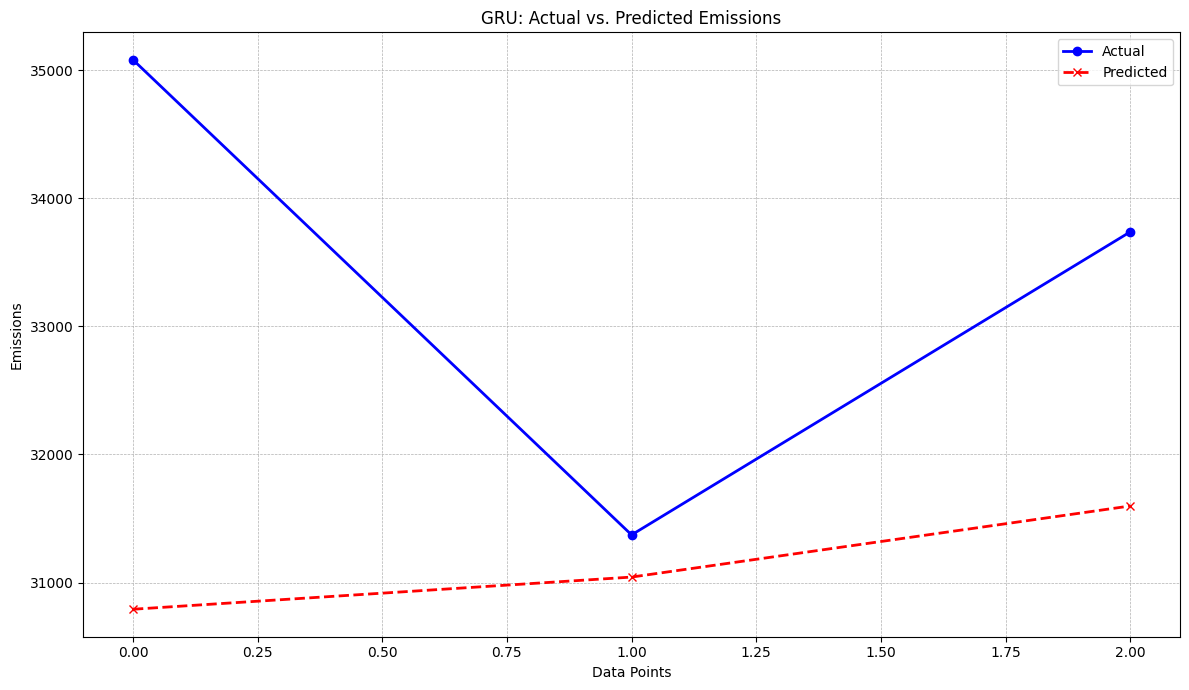

In [ ]:
plot_actual_vs_predicted(y_test, y_pred)

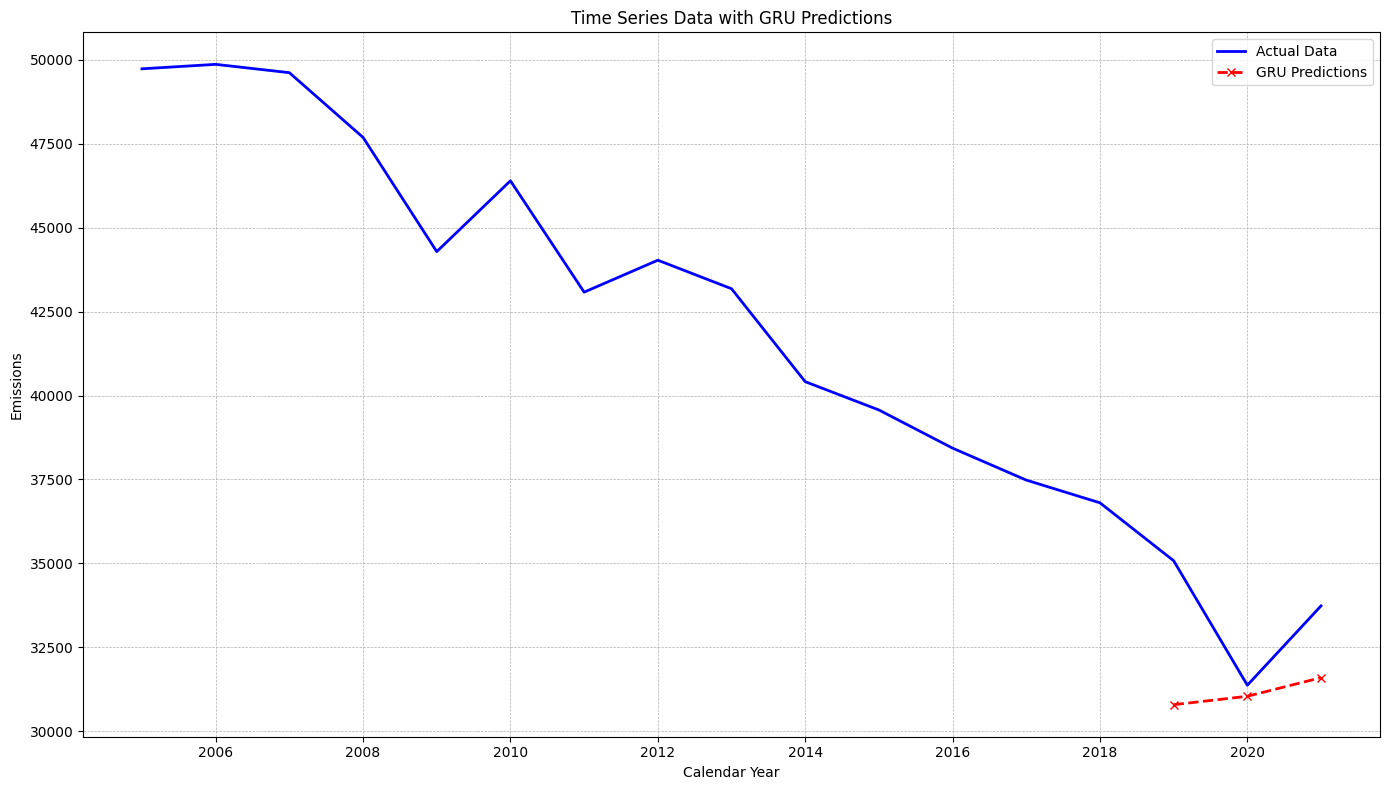

In [ ]:
import matplotlib.pyplot as plt

def plot_full_series_with_predictions(data, y_test, y_pred, start_idx):
    """
    Plot the entire time series data and overlay the GRU predictions on the test set.

    Parameters:
    - data: The entire time series data.
    - y_test: True values for the test set.
    - y_pred: Predicted values from the model for the test set.
    - start_idx: The index in the data where the test set begins.
    """
    # Inverse transform the predictions and actual values to the original scale
    y_pred_original = scaler.inverse_transform(y_pred)
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(14, 8))

    # Plot the entire data
    plt.plot(data.index, data.values, label='Actual Data', color='blue', linewidth=2)

    # Plot the predictions on top of the test set
    predicted_dates = data.index[start_idx:start_idx + len(y_pred)]
    plt.plot(predicted_dates, y_pred_original, marker='x', label='GRU Predictions', color='red', linestyle='dashed', linewidth=2)

    plt.title('Time Series Data with GRU Predictions')
    plt.ylabel('Emissions')
    plt.xlabel('Calendar Year')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Assuming 'grouped_data' is your entire time series data, 'y_test' are the true values, and 'y_pred' are the model's predictions
start_idx_of_test = len(grouped_data) - len(y_test)
plot_full_series_with_predictions(grouped_data, y_test, y_pred, start_idx_of_test)


In [ ]:
#!cp "/content/drive/My Drive/Colab Notebooks/Dissertation_Code.ipynb" "Dissertation_Code.ipynb"


In [ ]:
#!cp "/content/drive/My Drive/Colab Notebooks/topo_eer.csv" "topo_eer.csv"

<H1>SPARTIAL ANALYSIS</H1>

In [ ]:
import geopandas as gpd
import pandas as pd
#pip install geopandas
import json
from google.colab import drive
#drive.mount('/content/drive')
# Reading the TopoJSON file
#file_path = 'topo_eer.json'
#https://github.com/martinjc/UK-GeoJSON/blob/master/json/electoral/wal/topo_eer.json
#https://drive.google.com/file/d/1Y_lBZU_GUnl4qzN_sYaS8JzLpzEHMlwp/view?usp=sharing
#/content/drive/MyDrive/topo_eer.json
#topo_eer_gdf = gpd.read_file(file_path)



topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_eer.csv'
#/content/drive/MyDrive/Colab Notebooks/topo_eer.csv
#https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_eer.csv

topo_eer_gdf = pd.read_csv(topo_lad_csv_path)

# Displaying the first few rows to understand its structure
topo_eer_gdf

Unnamed: 0         id    EER13CD  EER13CDO                   EER13NM  \
0           0  E15000001  E15000001         1                North East   
1           1  E15000002  E15000002         2                North West   
2           2  E15000003  E15000003         3  Yorkshire and The Humber   
3           3  E15000004  E15000004         4             East Midlands   
4           4  E15000005  E15000005         5             West Midlands   
5           5  E15000006  E15000006         6                   Eastern   
6           6  E15000007  E15000007         7                    London   
7           7  E15000008  E15000008         8                South East   
8           8  E15000009  E15000009         9                South West   

                                            geometry  
0  MULTIPOLYGON (((-1.2252565022535702 54.6258513...  
1  MULTIPOLYGON (((-3.205370776233162 53.37164649...  
2  MULTIPOLYGON (((-0.5534904613704112 53.6904012...  
3  MULTIPOLYGON (((0.2688297226583032 52.81560973...  
4  POLYGON ((-1.8135631811756063 53.1325804218624...  
5  MULTIPOLYGON (((0.5404817635513712 51.51739773...  
6  MULTIPOLYGON (((-0.3211134143414016 51.4460347...  
7  MULTIPOLYGON (((-1.588550195496107 50.66282574...  
8  MULTIPOLYGON (((-6.398918714804379 49.86534415...

In [ ]:
import geopandas as gpd

# Reading the TopoJSON file
#file_path = '/content/drive/MyDrive/Colab Notebooks/topo_eer.json'
file_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_eer.json'
topo_eer_gdf = gpd.read_file(file_path)

# Displaying the first few rows to understand its structure
topo_eer_gdf.head()
topo_eer_gdf.to_csv('topo_eer.csv')

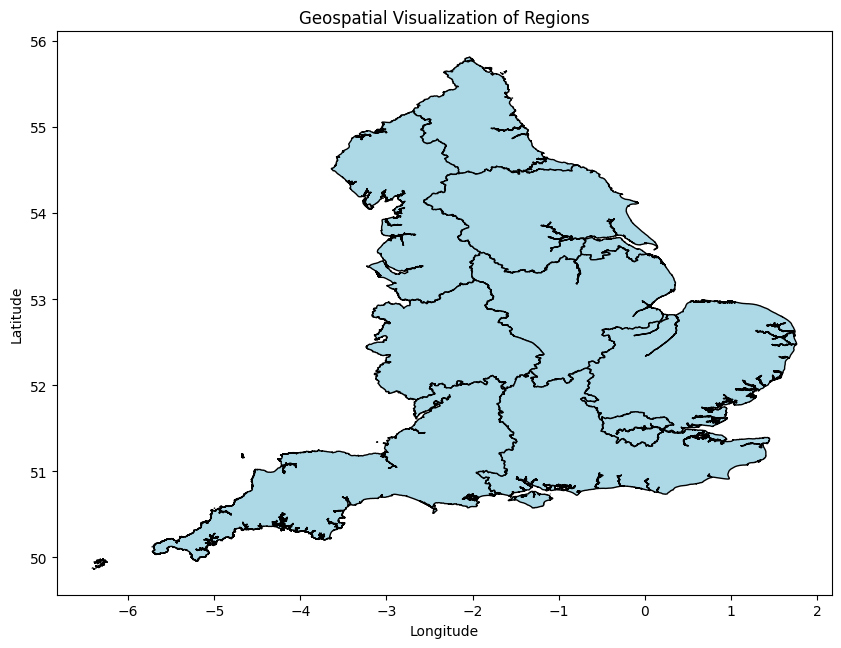

In [ ]:
import matplotlib.pyplot as plt

# Replotting the GeoDataFrame with the necessary library imported
topo_eer_gdf.plot(figsize=(10, 10), edgecolor='black', facecolor='lightblue')

# Adding title and axes labels
plt.title('Geospatial Visualization of Regions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Displaying the plot
plt.show()


In [ ]:
import pandas as pd

# Emissions data
emissions_data = {
    "Region/Country": ["East Midlands", "Eastern", "London", "North East", "North West",
                       "South East", "South West", "West Midlands", "Yorkshire and The Humber"],
    "Per Capita Emissions": [9.710848, 8.091197, 10.318067, 11.400630, 9.260969,
                             6.804080, 8.215306, 8.623030, 11.376461],
    "Emissions per km^2": [5.318442, 5.769531, 47.155219, 11.222972, 7.706417,
                           6.286119, 3.880700, 7.402992, 5.033133]
}

emissions_df = pd.DataFrame(emissions_data)

# Merging the emissions data with the geospatial data
merged_data = topo_eer_gdf.merge(emissions_df, left_on='EER13NM', right_on='Region/Country')

merged_data.head()  # Displaying the first few rows of the merged data for verification

id    EER13CD EER13CDO                   EER13NM  \
0  E15000001  E15000001       01                North East   
1  E15000002  E15000002       02                North West   
2  E15000003  E15000003       03  Yorkshire and The Humber   
3  E15000004  E15000004       04             East Midlands   
4  E15000005  E15000005       05             West Midlands   

                                            geometry  \
0  MULTIPOLYGON (((-1.22526 54.62585, -1.22444 54...   
1  MULTIPOLYGON (((-3.20537 53.37165, -3.20373 53...   
2  MULTIPOLYGON (((-0.55349 53.69040, -0.54613 53...   
3  MULTIPOLYGON (((0.26883 52.81561, 0.26392 52.8...   
4  POLYGON ((-1.81356 53.13258, -1.81356 53.13318...   

             Region/Country  Per Capita Emissions  Emissions per km^2  
0                North East             11.400630           11.222972  
1                North West              9.260969            7.706417  
2  Yorkshire and The Humber             11.376461            5.033133  
3             East Midlands              9.710848            5.318442  
4             West Midlands              8.623030            7.402992

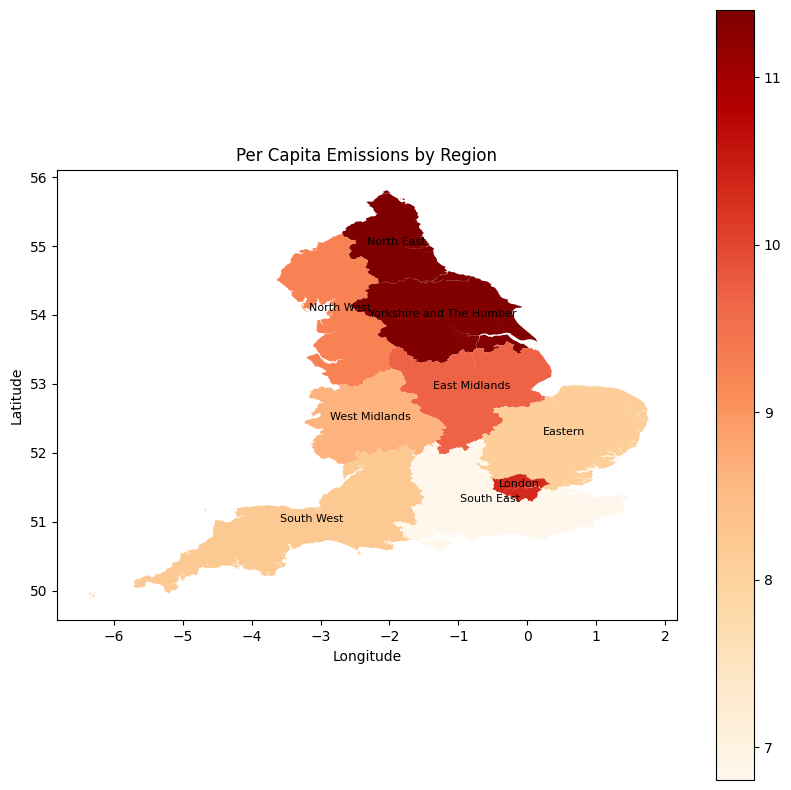

In [ ]:
import matplotlib.pyplot as plt

# Plotting the merged data with "Per Capita Emissions" as the color indicator
ax = merged_data.plot(column='Per Capita Emissions', cmap='OrRd', legend=True, figsize=(10, 10))

# Annotating each region with its name for clarity
for idx, row in merged_data.iterrows():
    pos = row['geometry'].centroid.coords[0]
    ax.annotate(text=row['Region/Country'], xy=pos, horizontalalignment='center', fontsize=8)

# Setting the title and labels
plt.title('Per Capita Emissions by Region')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Displaying the plot
plt.show()


<h3>Per capita emissions refer to the average release of emissions (carbon dioxide, CO2) attributed to each individual within a certain population.<h3/>

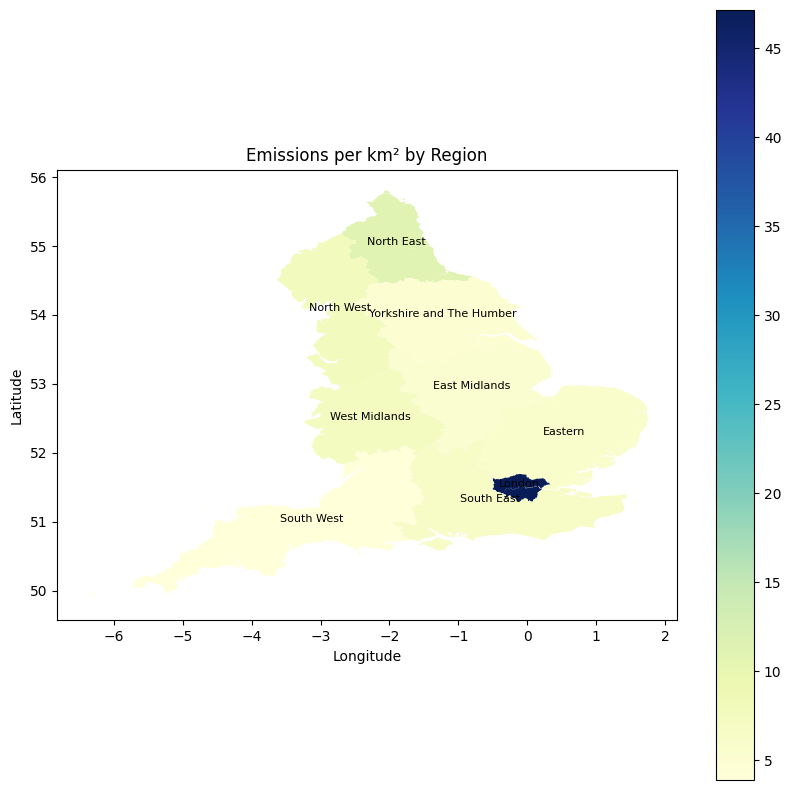

In [ ]:
# Plotting the merged data with "Emissions per km^2" as the color indicator
ax = merged_data.plot(column='Emissions per km^2', cmap='YlGnBu', legend=True, figsize=(10, 10))

# Annotating each region with its name for clarity
for idx, row in merged_data.iterrows():
    pos = row['geometry'].centroid.coords[0]
    ax.annotate(text=row['Region/Country'], xy=pos, horizontalalignment='center', fontsize=8)

# Setting the title and labels
plt.title('Emissions per km² by Region')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Displaying the plot
plt.show()

<h3>
The term "Average Emissions per km² by Region" refers to a measure used to understand the density of emissions in a given area. This metric provides an average value of emissions (carbon dioxide, CO2) distributed over the total land area of a region, expressed in square kilometers (km²)<h3/>

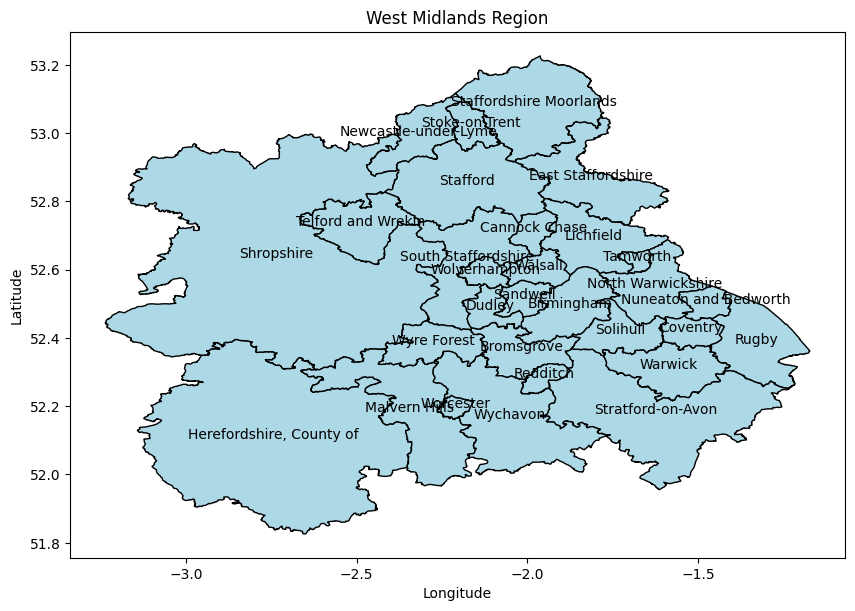

In [ ]:
# Reading the CSV file into a DataFrame
#topo_lad_csv_path = '/content/drive/MyDrive/Colab Notebooks/topo_lad_1.csv'
topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv'
#https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv

topo_lad_df = pd.read_csv('https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv')

#file_path = 'topo_lad.json'
#topo_lad_df = gpd.read_file(file_path)

# Converting the DataFrame to a GeoDataFrame
topo_lad_gdf = gpd.GeoDataFrame(topo_lad_df, geometry=gpd.GeoSeries.from_wkt(topo_lad_df['geometry']))

# Filtering for the specified areas
areas_to_visualize = [
    "Birmingham", "Bromsgrove", "Cannock Chase", "Coventry", "Dudley",
    "East Staffordshire", "Herefordshire, County of", "Lichfield", "Malvern Hills",
    "Newcastle-under-Lyme", "North Warwickshire", "Nuneaton and Bedworth", "Redditch",
    "Rugby", "Sandwell", "Shropshire", "Solihull", "South Staffordshire",
    "Stafford", "Staffordshire Moorlands", "Stoke-on-Trent", "Stratford-on-Avon",
    "Tamworth", "Telford and Wrekin", "Walsall", "Warwick", "Wolverhampton",
    "Worcester", "Wychavon", "Wyre Forest"
]

# Filtering the GeoDataFrame for the Westmidlands areas
filtered_gdf = topo_lad_gdf[topo_lad_gdf['LAD13NM'].isin(areas_to_visualize)]

# Plotting the "West Midlands" region
ax = filtered_gdf.plot(figsize=(10, 10), edgecolor='black', facecolor='lightblue')

# Annotating the region with its name
for idx, row in filtered_gdf.iterrows():
    pos = row['geometry'].centroid.coords[0]
    ax.annotate(text=row['LAD13NM'], xy=pos, horizontalalignment='center')

# Setting the title and labels
plt.title('West Midlands Region')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Displaying the plot
plt.show()

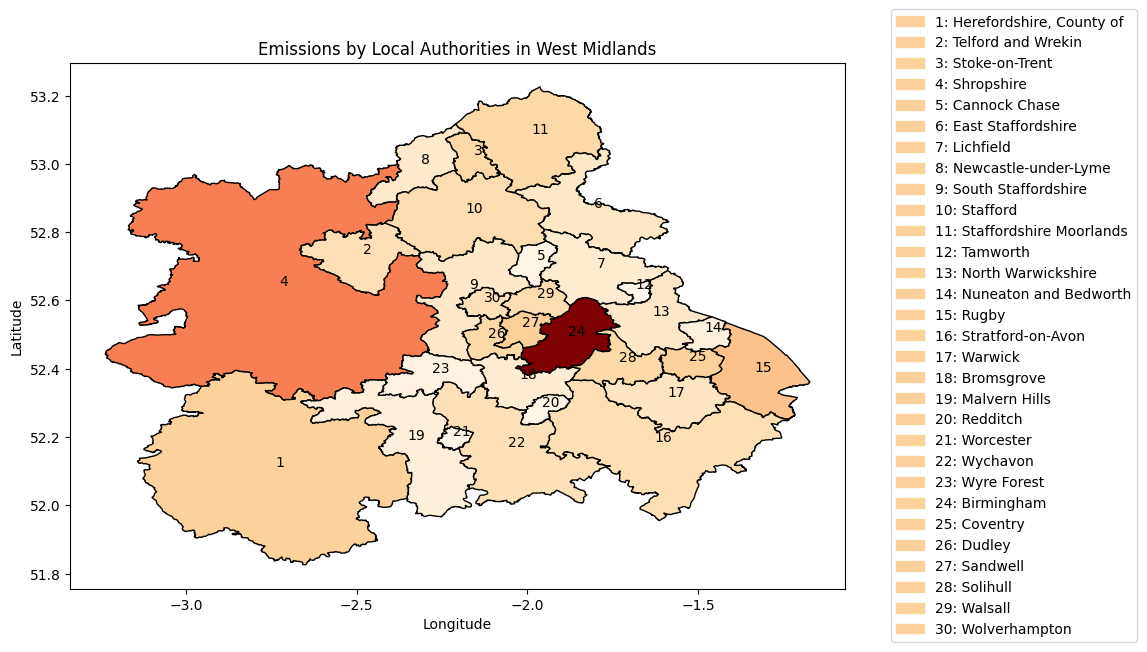

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


# Reading the CSV file into a DataFrame
topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv'
topo_lad_df = pd.read_csv(topo_lad_csv_path)

# Converting the DataFrame to a GeoDataFrame
topo_lad_gdf = gpd.GeoDataFrame(topo_lad_df, geometry=gpd.GeoSeries.from_wkt(topo_lad_df['geometry']))

areas_to_visualize = {
    "Local Authority": [
        "Birmingham", "Bromsgrove", "Cannock Chase", "Coventry", "Dudley",
        "East Staffordshire", "Herefordshire, County of", "Lichfield", "Malvern Hills",
        "Newcastle-under-Lyme", "North Warwickshire", "Nuneaton and Bedworth", "Redditch",
        "Rugby", "Sandwell", "Shropshire", "Solihull", "South Staffordshire",
        "Stafford", "Staffordshire Moorlands", "Stoke-on-Trent", "Stratford-on-Avon",
        "Tamworth", "Telford and Wrekin", "Walsall", "Warwick", "Wolverhampton",
        "Worcester", "Wychavon", "Wyre Forest"
    ],
    "Emissions": [
        96194.42, 14592.43, 8323.91, 29913.27, 26291.81,
        18530.12, 30369.14, 15314.26, 12044.33,
        16825.96, 18244.97, 11604.42, 8275.61,
        37092.39, 31099.31, 55209.7, 26119.39, 17940.00,
        24410.05, 26321.27, 26681.51, 23179.05,
        6411.41, 22889.89, 24428.08, 19614.43, 22070.84,
        8733.09, 22128.51, 9923.38
    ]
}

westmidlands_emissions_df = pd.DataFrame(areas_to_visualize)

# Filtering the GeoDataFrame for the specified areas
filtered_gdf = topo_lad_gdf[topo_lad_gdf['LAD13NM'].isin(areas_to_visualize["Local Authority"])]

# Merging the emissions data with the geospatial data
filtered_gdf = filtered_gdf.merge(westmidlands_emissions_df, left_on='LAD13NM', right_on='Local Authority')

filtered_gdf['ID'] = range(1, len(filtered_gdf) + 1)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#filtered_gdf.plot(ax=ax, color='white', edgecolor='black')
filtered_gdf.plot(ax=ax, column='Emissions', cmap='OrRd', legend=False, edgecolor='black')

#filtered_gdf.plot(column='Emissions', cmap='OrRd', legend=True)


for idx, row in filtered_gdf.iterrows():
    plt.annotate(text=row['ID'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
             xytext=(5, 5), textcoords='offset points',
             horizontalalignment='center', verticalalignment='center')

from matplotlib.patches import Patch
legend_labels = [Patch(label=f'{row["ID"]}: {row["LAD13NM"]}', color = '#FDD19B') for idx, row in filtered_gdf.iterrows()]

plt.legend(handles=legend_labels, bbox_to_anchor=(1.05, 0.5), loc='center left')

# Setting the title and labels
plt.title('Emissions by Local Authorities in West Midlands')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Displaying the plot
plt.show()





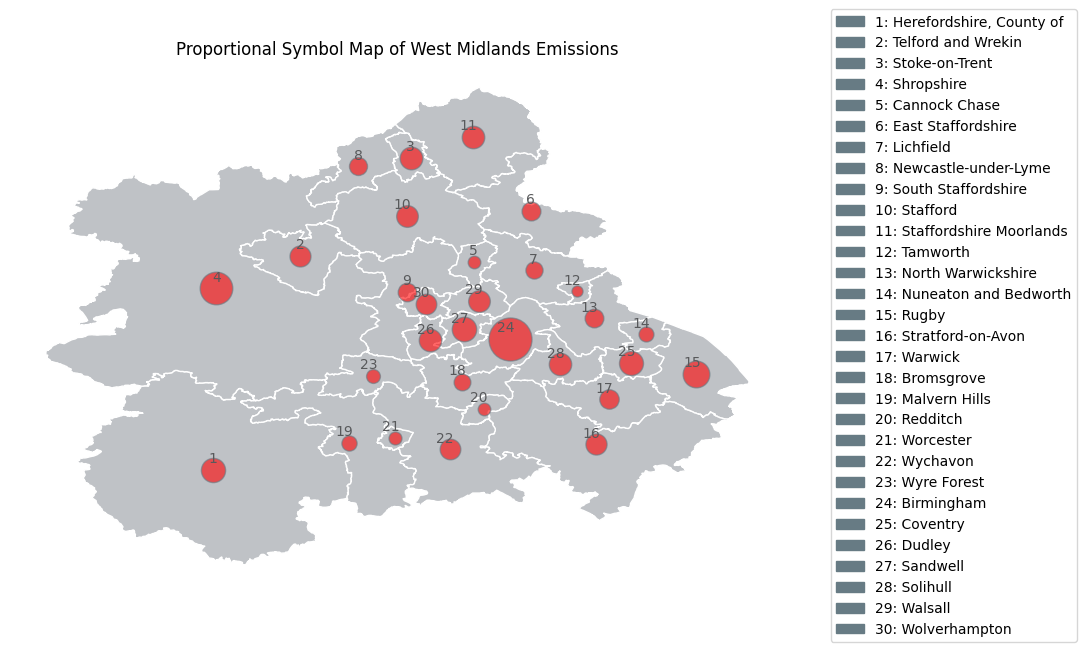

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv'
topo_lad_df = pd.read_csv(topo_lad_csv_path)

topo_lad_gdf = gpd.GeoDataFrame(topo_lad_df, geometry=gpd.GeoSeries.from_wkt(topo_lad_df['geometry']))

areas_to_visualize = {
    "Local Authority": [
        "Birmingham", "Bromsgrove", "Cannock Chase", "Coventry", "Dudley",
        "East Staffordshire", "Herefordshire, County of", "Lichfield", "Malvern Hills",
        "Newcastle-under-Lyme", "North Warwickshire", "Nuneaton and Bedworth", "Redditch",
        "Rugby", "Sandwell", "Shropshire", "Solihull", "South Staffordshire",
        "Stafford", "Staffordshire Moorlands", "Stoke-on-Trent", "Stratford-on-Avon",
        "Tamworth", "Telford and Wrekin", "Walsall", "Warwick", "Wolverhampton",
        "Worcester", "Wychavon", "Wyre Forest"
    ],
    "Emissions": [
        96194.42, 14592.43, 8323.91, 29913.27, 26291.81,
        18530.12, 30369.14, 15314.26, 12044.33,
        16825.96, 18244.97, 11604.42, 8275.61,
        37092.39, 31099.31, 55209.7, 26119.39, 17940.00,
        24410.05, 26321.27, 26681.51, 23179.05,
        6411.41, 22889.89, 24428.08, 19614.43, 22070.84,
        8733.09, 22128.51, 9923.38
    ]
}

West_Midlands_emissions_df = pd.DataFrame(areas_to_visualize)

filtered_gdf = topo_lad_gdf[topo_lad_gdf['LAD13NM'].isin(areas_to_visualize["Local Authority"])]
filtered_gdf = filtered_gdf.merge(West_Midlands_emissions_df, left_on='LAD13NM', right_on='Local Authority')

filtered_gdf['ID'] = range(1, len(filtered_gdf) + 1)

fig, ax = plt.subplots(figsize=(10, 10))
filtered_gdf.plot(ax=ax, color='#BFC2C6', edgecolor='white')

filtered_gdf['centroid'] = filtered_gdf.geometry.centroid

for idx, row in filtered_gdf.iterrows():
    ax.scatter(row['centroid'].x, row['centroid'].y, s=row['Emissions'] / 100, edgecolor='#677B84', color='red', alpha=0.6)

if 'ID' in filtered_gdf.columns:
    for idx, row in filtered_gdf.iterrows():
        plt.annotate(text=row['ID'], xy=(row['centroid'].x, row['centroid'].y),
                     xytext=(3, 3), textcoords="offset points", color='#58595B',
                     horizontalalignment='right', verticalalignment='bottom')

from matplotlib.patches import Patch
legend_labels = [Patch(label=f'{row["ID"]}: {row["LAD13NM"]}', color = '#677B84') for idx, row in filtered_gdf.iterrows()]

plt.legend(handles=legend_labels, bbox_to_anchor=(1.05, 0.5), loc='center left')

ax.set_title('Proportional Symbol Map of West Midlands Emissions')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.axis('off')
plt.show()


<h1>London</h1>

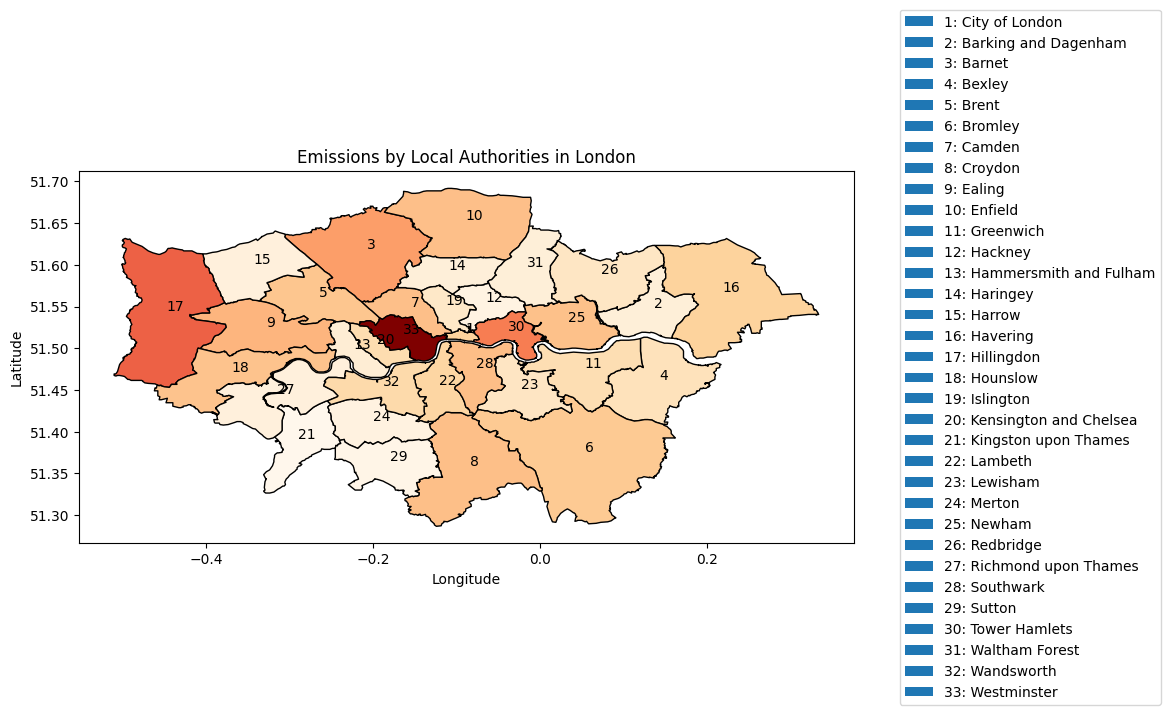

In [ ]:
import geopandas as gpd
#pip install geopandas
import pandas as pd
import matplotlib.pyplot as plt

# Reading the CSV file into a DataFrame
#topo_lad_csv_path = '/content/drive/MyDrive/Colab Notebooks/topo_lad_1.csv'
topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv'
#https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv
topo_lad_df = pd.read_csv(topo_lad_csv_path)

# Converting the DataFrame to a GeoDataFrame
topo_lad_gdf = gpd.GeoDataFrame(topo_lad_df, geometry=gpd.GeoSeries.from_wkt(topo_lad_df['geometry']))


areas_to_visualize = {
    "Local Authority": [
        "Barking and Dagenham", "Barnet", "Bexley", "Brent", "Bromley",
        "Camden", "City of London", "Croydon", "Ealing", "Enfield",
        "Greenwich", "Hackney", "Hammersmith and Fulham", "Haringey", "Harrow",
        "Havering", "Hillingdon", "Hounslow", "Islington", "Kensington and Chelsea",
        "Kingston upon Thames", "Lambeth", "Lewisham", "Merton", "Newham",
        "Redbridge", "Richmond upon Thames", "Southwark", "Sutton", "Tower Hamlets",
        "Waltham Forest", "Wandsworth", "Westminster"
    ],
    "Emissions": [
        15463.91025, 28691.27869, 18692.49984, 24094.3711, 23449.86935,
        25153.52172, 21824.12753, 25312.44843, 26508.9953, 25266.11173,
        19444.03101, 14131.06025, 15768.98906, 15256.69209, 14873.18658,
        21802.04362, 35004.48549, 24510.70171, 17262.92168, 19815.56886,
        12900.68594, 21174.76154, 17832.82757, 14467.75162, 24878.6207,
        17747.91536, 14933.43661, 25433.82893, 13510.13559, 31954.69088,
        15380.36485, 20286.94346, 47718.18393
    ]
}

London_emissions_df = pd.DataFrame(areas_to_visualize)

# Filtering the GeoDataFrame for the specified areas
filtered_gdf = topo_lad_gdf[topo_lad_gdf['LAD13NM'].isin(areas_to_visualize["Local Authority"])]

# Merging the emissions data with the geospatial data
filtered_gdf = filtered_gdf.merge(London_emissions_df, left_on='LAD13NM', right_on='Local Authority')

filtered_gdf['ID'] = range(1, len(filtered_gdf) + 1)


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#filtered_gdf.plot(ax=ax, color='white', edgecolor='black')
filtered_gdf.plot(ax=ax, column='Emissions', cmap='OrRd', legend=False, edgecolor='black')


for idx, row in filtered_gdf.iterrows():
    plt.annotate(text=row['ID'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
             xytext=(5, 5), textcoords='offset points',
             horizontalalignment='center', verticalalignment='center')

from matplotlib.patches import Patch
legend_labels = [Patch(label=f'{row["ID"]}: {row["LAD13NM"]}') for idx, row in filtered_gdf.iterrows()]

plt.legend(handles=legend_labels, bbox_to_anchor=(1.05, 0.5), loc='center left')


# Setting the title and labels
plt.title('Emissions by Local Authorities in London')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Displaying the plot
plt.show()


<h1>North East</h1>

In [ ]:
# Filter the data for the "North East" Region/Country
North_East_data = data_1_1_actual[data_1_1_actual['Region/Country'] == 'North East']
North_East_data

3   Region/Country Second Tier Authority Local Authority Local Authority Code  \
0       North East            Darlington      Darlington            E06000005   
1       North East            Darlington      Darlington            E06000005   
2       North East            Darlington      Darlington            E06000005   
3       North East            Darlington      Darlington            E06000005   
4       North East            Darlington      Darlington            E06000005   
..             ...                   ...             ...                  ...   
199     North East            Sunderland      Sunderland            E08000024   
200     North East            Sunderland      Sunderland            E08000024   
201     North East            Sunderland      Sunderland            E08000024   
202     North East            Sunderland      Sunderland            E08000024   
203     North East            Sunderland      Sunderland            E08000024   

3   Calendar Year Industry Electricity Industry Gas   \
0            2005             51.87311    114.701874   
1            2006            55.398988     97.614091   
2            2007            52.249398     95.167732   
3            2008            51.651166     95.266031   
4            2009            45.607413     82.045964   
..            ...                  ...           ...   
199          2017           128.137065    106.809231   
200          2018           136.925612    120.282851   
201          2019           115.537836    114.592329   
202          2020            86.552482     98.413894   
203          2021            98.614591    115.829338   

3   Large Industrial Installations Industry 'Other' Industry Total  ...  \
0                         0.045681        43.073543     209.694209  ...   
1                         0.065836        42.086928     195.165842  ...   
2                         0.074503         43.79521     191.286843  ...   
3                         0.055964        35.982972     182.956132  ...   
4                         1.061014        26.863721     155.578112  ...   
..                             ...              ...            ...  ...   
199                       0.363709        76.826968     312.136973  ...   
200                       0.285963        85.944492     343.438917  ...   
201                       0.180324        76.458639     306.769128  ...   
202                       0.262282         69.95378     255.182438  ...   
203                       0.310952        78.275104     293.029984  ...   

3   Agriculture Soils Agriculture Total   Landfill Waste Management 'Other'  \
0           12.699185           63.7069  34.256022                 5.613394   
1           11.659759         59.927177  31.802024                  6.57408   
2           12.166507         59.716732  37.048534                  6.81813   
3            12.55795         59.566044   7.662955                 6.771385   
4           11.405542         57.689627  16.001037                 6.053694   
..                ...               ...        ...                      ...   
199          2.238043          6.860739  30.721376                17.009198   
200          2.237006          6.892021  16.240975                 16.95804   
201          2.385417          7.704898  37.115286                16.508094   
202          1.799352          6.923983  42.185583                15.602312   
203          2.394695          8.846119  21.031675                16.733311   

3   Waste Management Total  Grand Total Population ('000s, mid-year estimate)  \
0                39.869415   968.661604                               100.287   
1                38.376104   943.627506                               101.509   
2                43.866664   925.275164                               102.632   
3                 14.43434   876.045542                               103.694   
4                22.054731   805.592471                               104.355   
..                

In [ ]:
# Filter out rows where "Second Tier Authority" ends with "Total"
North_East_data_filtered = North_East_data[~North_East_data['Second Tier Authority'].str.endswith("Total")]

In [ ]:
North_East_data_filtered

3   Region/Country Second Tier Authority Local Authority Local Authority Code  \
0       North East            Darlington      Darlington            E06000005   
1       North East            Darlington      Darlington            E06000005   
2       North East            Darlington      Darlington            E06000005   
3       North East            Darlington      Darlington            E06000005   
4       North East            Darlington      Darlington            E06000005   
..             ...                   ...             ...                  ...   
199     North East            Sunderland      Sunderland            E08000024   
200     North East            Sunderland      Sunderland            E08000024   
201     North East            Sunderland      Sunderland            E08000024   
202     North East            Sunderland      Sunderland            E08000024   
203     North East            Sunderland      Sunderland            E08000024   

3   Calendar Year Industry Electricity Industry Gas   \
0            2005             51.87311    114.701874   
1            2006            55.398988     97.614091   
2            2007            52.249398     95.167732   
3            2008            51.651166     95.266031   
4            2009            45.607413     82.045964   
..            ...                  ...           ...   
199          2017           128.137065    106.809231   
200          2018           136.925612    120.282851   
201          2019           115.537836    114.592329   
202          2020            86.552482     98.413894   
203          2021            98.614591    115.829338   

3   Large Industrial Installations Industry 'Other' Industry Total  ...  \
0                         0.045681        43.073543     209.694209  ...   
1                         0.065836        42.086928     195.165842  ...   
2                         0.074503         43.79521     191.286843  ...   
3                         0.055964        35.982972     182.956132  ...   
4                         1.061014        26.863721     155.578112  ...   
..                             ...              ...            ...  ...   
199                       0.363709        76.826968     312.136973  ...   
200                       0.285963        85.944492     343.438917  ...   
201                       0.180324        76.458639     306.769128  ...   
202                       0.262282         69.95378     255.182438  ...   
203                       0.310952        78.275104     293.029984  ...   

3   Agriculture Soils Agriculture Total   Landfill Waste Management 'Other'  \
0           12.699185           63.7069  34.256022                 5.613394   
1           11.659759         59.927177  31.802024                  6.57408   
2           12.166507         59.716732  37.048534                  6.81813   
3            12.55795         59.566044   7.662955                 6.771385   
4           11.405542         57.689627  16.001037                 6.053694   
..                ...               ...        ...                      ...   
199          2.238043          6.860739  30.721376                17.009198   
200          2.237006          6.892021  16.240975                 16.95804   
201          2.385417          7.704898  37.115286                16.508094   
202          1.799352          6.923983  42.185583                15.602312   
203          2.394695          8.846119  21.031675                16.733311   

3   Waste Management Total  Grand Total Population ('000s, mid-year estimate)  \
0                39.869415   968.661604                               100.287   
1                38.376104   943.627506                               101.509   
2                43.866664   925.275164                               102.632   
3                 14.43434   876.045542                               103.694   
4                22.054731   805.592471                               104.355   
..                

In [ ]:
# Pivot table creation
pivot_table = pd.pivot_table(
    North_East_data_filtered,
    values=[
        'Commercial Total', 'Waste Management Total', 'Agriculture Total',
        'Transport Total', 'Domestic Total', 'Public Sector Total',
        'Industry Total', 'LULUCF Net Emissions','Emissions per km2 (kt CO2e)'
    ],
    index=['Calendar Year'],
    aggfunc=sum
)

# Transpose the pivot table to have categories as rows and years as columns
pivot_table_transposed = pivot_table.T

In [ ]:
pivot_table

3              Agriculture Total  Commercial Total  Domestic Total  \
Calendar Year                                                        
2005                 1508.897279       2654.787905     6974.540568   
2006                 1457.458095       2709.629509     6887.369750   
2007                 1460.878599       2570.063014     6625.876156   
2008                 1463.778351       2475.683112     6636.977992   
2009                 1408.700513       2109.421312     6026.089208   
2010                 1411.889536       2213.043974     6437.297369   
2011                 1367.405792       1978.849274     5648.070792   
2012                 1408.352086       2147.214053     6032.380514   
2013                 1364.494623       2052.930238     5933.868428   
2014                 1380.168862       1736.554521     5002.854506   
2015                 1405.796530       1549.320037     4866.884765   
2016                 1381.925833       1329.197634     4601.158944   
2017                 1401.592248        957.410440     4416.861924   
2018                 1403.590612        638.399737     4280.957201   
2019                 1379.808482        563.164326     4136.318576   
2020                 1309.930988        476.037825     4049.595342   
2021                 1342.482740        565.106096     4172.692067   

3              Emissions per km2 (kt CO2e)  Industry Total  \
Calendar Year                                                
2005                            194.514762    21582.081509   
2006                            189.140645    20628.346328   
2007                            189.347349    20712.336372   
2008                            181.753774    20161.506608   
2009                            158.354254    16194.970593   
2010                            143.772201    12091.949044   
2011                            125.001393     9852.518813   
2012                            149.840775    14196.560140   
2013                            149.673577    14371.336888   
2014                            134.384163    12853.725117   
2015                            124.653574    10794.011379   
2016                             99.357298     5661.455339   
2017                             97.972419     5993.141376   
2018                             94.376942     5804.961662   
2019                             91.465436     5481.036312   
2020                             83.275907     4998.767011   
2021                             82.601724     4309.491534   

3              LULUCF Net Emissions  Public Sector Total  Transport Total  \
Calendar Year                                                               
2005                    -430.562077          1144.688619      5127.278712   
2006                    -447.490231          1099.033963      5027.280400   
2007                    -465.556530          1035.660314      5041.577526   
2008                    -501.026442           981.823539      4822.803622   
2009                    -507.315230           855.620499      4667.087523   
2010                    -506.872082           921.199270      4591.594408   
2011                    -522.720319           814.095521      4528.332573   
2012                    -444.356811           877.935807      4486.821613   
2013                    -492.603674           852.452726      4423.432893   
2014                    -487.892389           713.997913      4456.308595   
2015                    -473.214316           670.672329      4519.098584   
2016                    -434.738284           570.542798      4558.808273   
2017                    -465.883843           631.332878      4584.967366   
2018                    -451.539967           667.624939      4569.212345   
2019                    -453.795928           594.544228      4557.709260   
2020                    -455.653031           552.148273      3715.376463   
2021                    -443.894164           614.709836      3958.754954   

3              Waste Manag

In [ ]:
pivot_table_transposed

Calendar Year                        2005          2006          2007  \
3                                                                       
Agriculture Total             1508.897279   1457.458095   1460.878599   
Commercial Total              2654.787905   2709.629509   2570.063014   
Domestic Total                6974.540568   6887.369750   6625.876156   
Emissions per km2 (kt CO2e)    194.514762    189.140645    189.347349   
Industry Total               21582.081509  20628.346328  20712.336372   
LULUCF Net Emissions          -430.562077   -447.490231   -465.556530   
Public Sector Total           1144.688619   1099.033963   1035.660314   
Transport Total               5127.278712   5027.280400   5041.577526   
Waste Management Total        1878.735718   1770.091829   1728.938187   

Calendar Year                        2008          2009          2010  \
3                                                                       
Agriculture Total             1463.778351   1408.700513   1411.889536   
Commercial Total              2475.683112   2109.421312   2213.043974   
Domestic Total                6636.977992   6026.089208   6437.297369   
Emissions per km2 (kt CO2e)    181.753774    158.354254    143.772201   
Industry Total               20161.506608  16194.970593  12091.949044   
LULUCF Net Emissions          -501.026442   -507.315230   -506.872082   
Public Sector Total            981.823539    855.620499    921.199270   
Transport Total               4822.803622   4667.087523   4591.594408   
Waste Management Total        1320.267966   1344.228991   1115.869285   

Calendar Year                       2011          2012          2013  \
3                                                                      
Agriculture Total            1367.405792   1408.352086   1364.494623   
Commercial Total             1978.849274   2147.214053   2052.930238   
Domestic Total               5648.070792   6032.380514   5933.868428   
Emissions per km2 (kt CO2e)   125.001393    149.840775    149.673577   
Industry Total               9852.518813  14196.560140  14371.336888   
LULUCF Net Emissions         -522.720319   -444.356811   -492.603674   
Public Sector Total           814.095521    877.935807    852.452726   
Transport Total              4528.332573   4486.821613   4423.432893   
Waste Management Total        949.298220    986.431063    756.797536   

Calendar Year                        2014          2015         2016  \
3                                                                      
Agriculture Total             1380.168862   1405.796530  1381.925833   
Commercial Total              1736.554521   1549.320037  1329.197634   
Domestic Total                5002.854506   4866.884765  4601.158944   
Emissions per km2 (kt CO2e)    134.384163    124.653574    99.357298   
Industry Total               12853.725117  10794.011379  5661.455339   
LULUCF Net Emissions          -487.892389   -473.214316  -434.738284   
Public Sector Total            713.997913    670.672329   570.542798   
Transport Total               4456.308595   4519.098584  4558.808273   
Waste Management Total         733.427306    798.180900   649.560793   

Calendar Year                       2017         2018         2019  \
3                                                                    
Agriculture Total            1401.592248  1403.590612  1379.808482   
Commercial Total              957.410440   638.399737   563.164326   
Domestic Total               4416.861924  4280.957201  4136.318576   
Emissions per km2 (kt CO2e)    97.972419    94.376942    91.465436   
Industry Total               5993.141376  5804.961662  5481.036312   
LULUCF Net Emissions         -465.883843  -451.539967  -453.795928   
Public Sector Total           631.332878   667.624939   594.544228   
Transport Total              4584.967366  4569.212345  4557.709260   
Waste Management Total        635.507730   639.421892   601.776726   

Calendar Year                      

In [ ]:
pivot_table_transposed.corr()

Calendar Year      2005      2006      2007      2008      2009      2010  \
Calendar Year                                                               
2005           1.000000  0.999897  0.999956  0.999704  0.997506  0.973308   
2006           0.999897  1.000000  0.999889  0.999795  0.998196  0.976136   
2007           0.999956  0.999889  1.000000  0.999755  0.997767  0.973781   
2008           0.999704  0.999795  0.999755  1.000000  0.998165  0.975961   
2009           0.997506  0.998196  0.997767  0.998165  1.000000  0.986349   
2010           0.973308  0.976136  0.973781  0.975961  0.986349  1.000000   
2011           0.955213  0.958780  0.956189  0.958644  0.973364  0.996821   
2012           0.992028  0.993507  0.992402  0.993749  0.998183  0.993967   
2013           0.992664  0.994033  0.993064  0.994559  0.998319  0.992573   
2014           0.990834  0.992066  0.991625  0.992664  0.997466  0.990647   
2015           0.977245  0.979296  0.978345  0.979743  0.989529  0.994714   
2016           0.828474  0.834583  0.830926  0.834837  0.865655  0.927789   
2017           0.851290  0.856416  0.853647  0.856996  0.885624  0.938276   
2018           0.842059  0.846858  0.844414  0.847606  0.876884  0.928937   
2019           0.825552  0.830493  0.828100  0.831309  0.862005  0.916748   
2020           0.837428  0.842474  0.839264  0.843142  0.872955  0.930022   
2021           0.763406  0.769710  0.765707  0.770518  0.806333  0.880900   

Calendar Year      2011      2012      2013      2014      2015      2016  \
Calendar Year                                                               
2005           0.955213  0.992028  0.992664  0.990834  0.977245  0.828474   
2006           0.958780  0.993507  0.994033  0.992066  0.979296  0.834583   
2007           0.956189  0.992402  0.993064  0.991625  0.978345  0.830926   
2008           0.958644  0.993749  0.994559  0.992664  0.979743  0.834837   
2009           0.973364  0.998183  0.998319  0.997466  0.989529  0.865655   
2010           0.996821  0.993967  0.992573  0.990647  0.994714  0.927789   
2011           1.000000  0.984229  0.982309  0.982721  0.992974  0.954052   
2012           0.984229  1.000000  0.999849  0.998436  0.994279  0.889135   
2013           0.982309  0.999849  1.000000  0.998623  0.993652  0.885237   
2014           0.982721  0.998436  0.998623  1.000000  0.996518  0.892887   
2015           0.992974  0.994279  0.993652  0.996518  1.000000  0.926928   
2016           0.954052  0.889135  0.885237  0.892887  0.926928  1.000000   
2017           0.961709  0.905715  0.902504  0.911389  0.942324  0.997021   
2018           0.953171  0.896482  0.893371  0.903443  0.935476  0.993458   
2019           0.943250  0.882406  0.879165  0.890370  0.924568  0.992755   
2020           0.952926  0.894102  0.890564  0.897595  0.930298  0.992057   
2021           0.912757  0.833460  0.829145  0.837677  0.879546  0.988651   

Calendar Year      2017      2018      2019      2020      2021  
Calendar Year                                                    
2005           0.851290  0.842059  0.825552  0.837428  0.763406  
2006           0.856416  0.846858  0.830493  0.842474  0.769710  
2007           0.853647  0.844414  0.828100  0.839264  0.765707  
2008           0.856996  0.847606  0.831309  0.843142  0.770518  
2009           0.885624  0.876884  0.862005  0.872955  0.806333  
2010           0.938276  0.928937  0.916748  0.930022  0.880900  
2011           0.961709  0.953171  0.943250  0.952926  0.912757  
2012           0.905715  0.896482  0.882406  0.894102  0.833460  
2013           0.902504  0.893371  0.879165  0.890564  0.829145  
2014           0.911389  0.903443  0.890370  0.897595  0.837677  
2015           0.942324  0.935476  0.924568  0.930298  0.879546  
2016           0.997021  0.993458  0.992755  0.992057  0.988651  
2017           1.000000  0.998804  0.997506  0.995865  0.986200  
2018           0.998804  1.000000  0.999462  0.996884  0.988210  
2019           0

In [ ]:
pivot_table.corr()

3                            Agriculture Total  Commercial Total  \
3                                                                  
Agriculture Total                     1.000000          0.737742   
Commercial Total                      0.737742          1.000000   
Domestic Total                        0.765560          0.973800   
Emissions per km2 (kt CO2e)           0.822794          0.959502   
Industry Total                        0.809252          0.934834   
LULUCF Net Emissions                  0.112696         -0.297315   
Public Sector Total                   0.822014          0.922232   
Transport Total                       0.928138          0.743042   
Waste Management Total                0.850879          0.853879   

3                            Domestic Total  Emissions per km2 (kt CO2e)  \
3                                                                          
Agriculture Total                  0.765560                     0.822794   
Commercial Total                   0.973800                     0.959502   
Domestic Total                     1.000000                     0.965109   
Emissions per km2 (kt CO2e)        0.965109                     1.000000   
Industry Total                     0.940734                     0.995040   
LULUCF Net Emissions              -0.257496                    -0.180073   
Public Sector Total                0.972771                     0.959964   
Transport Total                    0.734094                     0.784377   
Waste Management Total             0.897786                     0.923009   

3                            Industry Total  LULUCF Net Emissions  \
3                                                                   
Agriculture Total                  0.809252              0.112696   
Commercial Total                   0.934834             -0.297315   
Domestic Total                     0.940734             -0.257496   
Emissions per km2 (kt CO2e)        0.995040             -0.180073   
Industry Total                     1.000000             -0.167389   
LULUCF Net Emissions              -0.167389              1.000000   
Public Sector Total                0.943750             -0.135616   
Transport Total                    0.755793             -0.006746   
Waste Management Total             0.915906             -0.015925   

3                            Public Sector Total  Transport Total  \
3                                                                   
Agriculture Total                       0.822014         0.928138   
Commercial Total                        0.922232         0.743042   
Domestic Total                          0.972771         0.734094   
Emissions per km2 (kt CO2e)             0.959964         0.784377   
Industry Total                          0.943750         0.755793   
LULUCF Net Emissions                   -0.135616        -0.006746   
Public Sector Total                     1.000000         0.768144   
Transport Total                         0.768144         1.000000   
Waste Management Total                  0.936951         0.795368   

3                            Waste Management Total  
3                                                    
Agriculture Total                          0.850879  
Commercial Total                           0.853879  
Domestic Total                             0.897786  
Emissions per km2 (kt CO2e)                0.923009  
Industry Total                             0.915906  
LULUCF Net Emissions                      -0.015925  
Public Sector Total                        0.936951  
Transport Total                            0.795368  
Waste Management Total                     1.000000

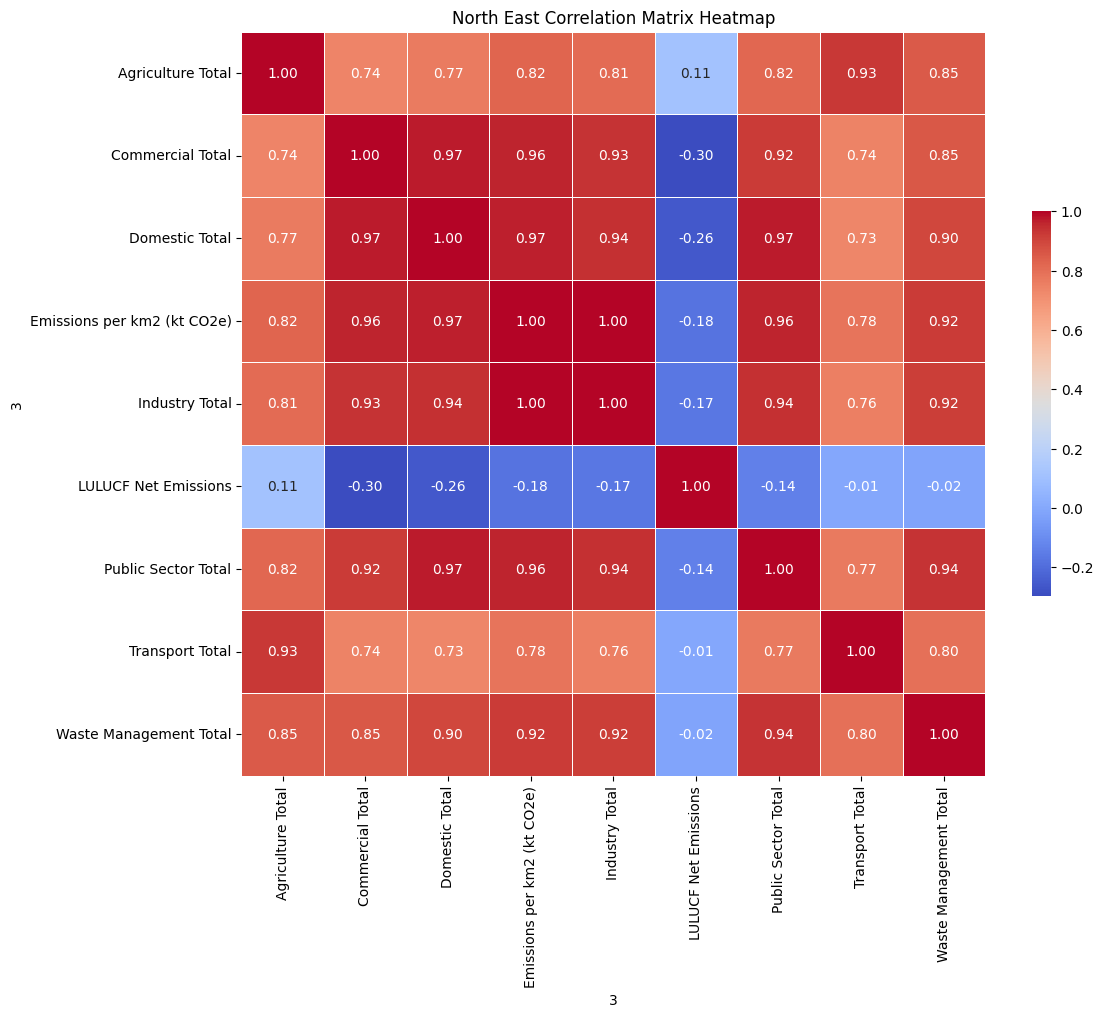

In [ ]:
# Generate the correlation matrix
corr = pivot_table.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Add title
plt.title('North East Correlation Matrix Heatmap')

# Show the plot
plt.show()


Values close to 1 indicate a strong positive correlation, meaning that as one feature increases, the other tends to increase as well.

Values close to -1 indicate a strong negative correlation, meaning that as one feature increases, the other tends to decrease.

Values close to 0 indicate little to no linear relationship between the features.

In [ ]:
# List of columns to keep
columns_to_keep = ['Region/Country', 'Second Tier Authority', 'Local Authority', 'Local Authority Code', 'Calendar Year', 'LULUCF Net Emissions']
# Add columns that end with "Total"
columns_to_keep.extend([col for col in North_East_data_filtered.columns if col.endswith("Total")])

In [ ]:
North_East_filtered_columns = North_East_data_filtered[columns_to_keep]

North_East_filtered_columns.to_csv('North_East_filtered_columns.csv')
North_East_filtered_columns

3   Region/Country Second Tier Authority Local Authority Local Authority Code  \
0       North East            Darlington      Darlington            E06000005   
1       North East            Darlington      Darlington            E06000005   
2       North East            Darlington      Darlington            E06000005   
3       North East            Darlington      Darlington            E06000005   
4       North East            Darlington      Darlington            E06000005   
..             ...                   ...             ...                  ...   
199     North East            Sunderland      Sunderland            E08000024   
200     North East            Sunderland      Sunderland            E08000024   
201     North East            Sunderland      Sunderland            E08000024   
202     North East            Sunderland      Sunderland            E08000024   
203     North East            Sunderland      Sunderland            E08000024   

3   Calendar Year LULUCF Net Emissions Industry Total Commercial Total  \
0            2005             2.299746     209.694209       106.102562   
1            2006             2.392004     195.165842       110.638518   
2            2007             1.966591     191.286843       104.635542   
3            2008             1.222063     182.956132       103.693416   
4            2009              1.57696     155.578112        91.333508   
..            ...                  ...            ...              ...   
199          2017             0.602222     312.136973        86.204914   
200          2018             0.772228     343.438917        49.767614   
201          2019             0.660094     306.769128        41.920995   
202          2020             0.612685     255.182438        34.033768   
203          2021             0.603979     293.029984        39.120582   

3   Public Sector Total Domestic Total Transport Total Agriculture Total  \
0             40.767098     281.679013       224.54266           63.7069   
1             39.049079     278.808555      219.270227         59.927177   
2             37.053842     269.529776      217.219173         59.716732   
3             36.020472     271.336071      206.817004         59.566044   
4             31.346337     246.537719      199.475477         57.689627   
..                  ...            ...             ...               ...   
199           61.427001     446.890924      399.150179          6.860739   
200           59.669017     430.168527      397.720321          6.892021   
201           50.606282     416.269587      390.592578          7.704898   
202           46.133249     407.116749      318.461864          6.923983   
203           51.147145     418.890742      325.988126          8.846119   

3   Waste Management Total  Grand Total  
0                39.869415   968.661604  
1                38.376104   943.627506  
2                43.866664   925.275164  
3                 14.43434   876.045542  
4                22.054731   805.592471  
..                     ...          ...  
199              47.730574  1361.003527  
200              33.199015  1321.627660  
201               53.62338  1268.146942  
202              57.787895  1126.252631  
203              37.764987  1175.391665  

[204 rows x 14 columns]

In [ ]:
North_East_filtered_columns.dtypes

3
Region/Country             object
Second Tier Authority      object
Local Authority            object
Local Authority Code       object
Calendar Year              object
LULUCF Net Emissions       object
Industry Total             object
Commercial Total           object
Public Sector Total        object
Domestic Total             object
Transport Total            object
Agriculture Total          object
Waste Management Total     object
Grand Total               float64
dtype: object

In [ ]:
# Create the pivot table of west_midlands local authorities emission
North_East_local_authority_emissions = pd.pivot_table(North_East_filtered_columns, values='Grand Total', index=['Local Authority'], columns=['Calendar Year'])

North_East_local_authority_emissions.to_csv('North_East_filtered_columns_by_year.csv')
North_East_local_authority_emissions


Calendar Year                 2005          2006          2007          2008  \
Local Authority                                                                
County Durham          4936.436203   4835.316075   4719.307614   4502.578072   
Darlington              968.661604    943.627506    925.275164    876.045542   
Gateshead              1805.679907   1835.329580   1776.709461   1700.109058   
Hartlepool             1050.046919   1034.968189    994.819715    957.968022   
Middlesbrough          1159.446690   1155.835084   1218.699466   1079.426088   
Newcastle upon Tyne    2216.486844   2168.938742   2142.513627   2064.874942   
North Tyneside         1494.481510   1431.854568   1456.348946   1372.976149   
Northumberland         6041.530627   5831.305748   5339.651980   5097.706612   
Redcar and Cleveland  11782.974792  11198.526876  11519.699621  10844.796459   
South Tyneside          994.184708    972.682839    906.532537    863.045980   
Stockton-on-Tees       5683.842468   5457.640524   5513.343977   5875.510117   
Sunderland             2306.675960   2265.693912   2196.871529   2126.777707   

Calendar Year                2009         2010         2011         2012  \
Local Authority                                                            
County Durham         4204.958605  4293.516243  3912.123331  4099.635462   
Darlington             805.592471   841.635593   787.262940   798.930540   
Gateshead             1552.602864  1587.466891  1421.352386  1468.141613   
Hartlepool             904.456840  1001.985954   890.928584   932.645747   
Middlesbrough          970.439767   979.292546   911.071883   970.082709   
Newcastle upon Tyne   1920.696941  2003.924974  1805.631178  1880.029690   
North Tyneside        1240.392673  1271.651828  1198.162148  1248.630056   
Northumberland        4332.324607  4674.647551  4508.456141  3883.440831   
Redcar and Cleveland  8895.204035  3877.027342  3294.564589  8017.115897   
South Tyneside         801.221423   803.599760   751.254297   795.022154   
Stockton-on-Tees      4541.326196  4954.716359  3350.217073  3695.569973   
Sunderland            1929.586988  1986.505766  1784.826117  1902.093792   

Calendar Year                2013         2014         2015         2016  \
Local Authority                                                            
County Durham         3960.839767  3580.107058  3460.552288  3189.975322   
Darlington             779.983597   699.215550   689.651310   662.794271   
Gateshead             1390.161435  1257.557580  1207.101508  1146.010766   
Hartlepool             903.560709   832.525395   785.089482   706.844691   
Middlesbrough          869.178957   795.713465   823.925008   757.550999   
Newcastle upon Tyne   1840.930746  1610.967835  1570.997180  1472.901738   
North Tyneside        1186.628263  1074.246657  1012.677426   950.671249   
Northumberland        2609.344433  2418.634488  2461.717477  2359.116053   
Redcar and Cleveland  9625.235026  8735.878269  6686.751141  2171.966807   
South Tyneside         740.260788   627.596861   607.815754   567.361067   
Stockton-on-Tees      3609.688070  3141.852801  3294.239570  2911.861574   
Sunderland            1746.897867  1614.848470  1530.232066  1420.856793   

Calendar Year                2017         2018         2019         2020  \
Local Authority                                                            
County Durham         3107.091565  3107.637267  2991.967610  2668.525531   
Darlington             644.125829   628.280210   624.379411   592.318590   
Gateshead             1113.585405  1105.647498  1076.937213   945.287413   
Hartlepool             720.553814   695.667430   658.574373   647.897320   
Middlesbrough          715.199391   740.480310   727.748923   633.742627   
Newcastle upon Tyne   1396.713122  1337.408150  1287.002152  1135.692849   
North Tyneside         945.343740   890.030508   871.993100   821.412284   
Northumberland        2305.721564  2326.598953  2138.284368  1952

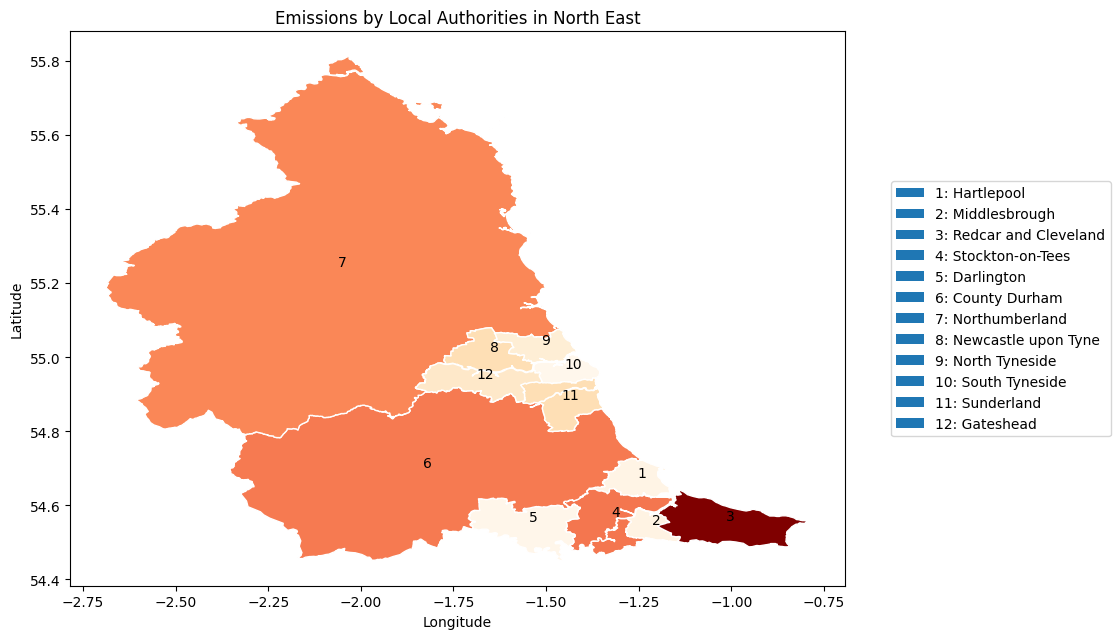

In [ ]:
import pandas as pd
# Reading the CSV file into a DataFrame
topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv'
topo_lad_df = pd.read_csv(topo_lad_csv_path)

# Converting the DataFrame to a GeoDataFrame
topo_lad_gdf = gpd.GeoDataFrame(topo_lad_df, geometry=gpd.GeoSeries.from_wkt(topo_lad_df['geometry']))


areas_to_visualize = {
    "Local Authority": ["County Durham", "Darlington", "Gateshead", "Hartlepool", "Middlesbrough",
                       "Newcastle upon Tyne", "North Tyneside", "Northumberland", "Redcar and Cleveland", "South Tyneside", "Stockton-on-Tees", "Sunderland"],
    "Emissions": [64421.44194, 12882.61833, 23387.99439, 14409.77169, 15161.56147,
                             29072.96486, 19330.82575, 60350.31757, 105582.7908, 12018.93366, 65626.36262, 29064.28939]
}


North_East_emissions_df = pd.DataFrame(areas_to_visualize)

# Filtering the GeoDataFrame for the specified areas
filtered_gdf = topo_lad_gdf[topo_lad_gdf['LAD13NM'].isin(areas_to_visualize["Local Authority"])]


# Merging the emissions data with the geospatial data
filtered_gdf = filtered_gdf.merge(North_East_emissions_df, left_on='LAD13NM', right_on='Local Authority')


filtered_gdf['ID'] = range(1, len(filtered_gdf) + 1)


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#filtered_gdf.plot(ax=ax, color='white', edgecolor='black')
filtered_gdf.plot(ax=ax, column='Emissions', cmap='OrRd', legend=False, edgecolor='white')


for idx, row in filtered_gdf.iterrows():
    plt.annotate(text=row['ID'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
             xytext=(5, 5), textcoords='offset points',
             horizontalalignment='center', verticalalignment='center')

from matplotlib.patches import Patch
legend_labels = [Patch(label=f'{row["ID"]}: {row["LAD13NM"]}') for idx, row in filtered_gdf.iterrows()]

plt.legend(handles=legend_labels, bbox_to_anchor=(1.05, 0.5), loc='center left')


# Setting the title and labels
plt.title('Emissions by Local Authorities in North East')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Displaying the plot
plt.show()




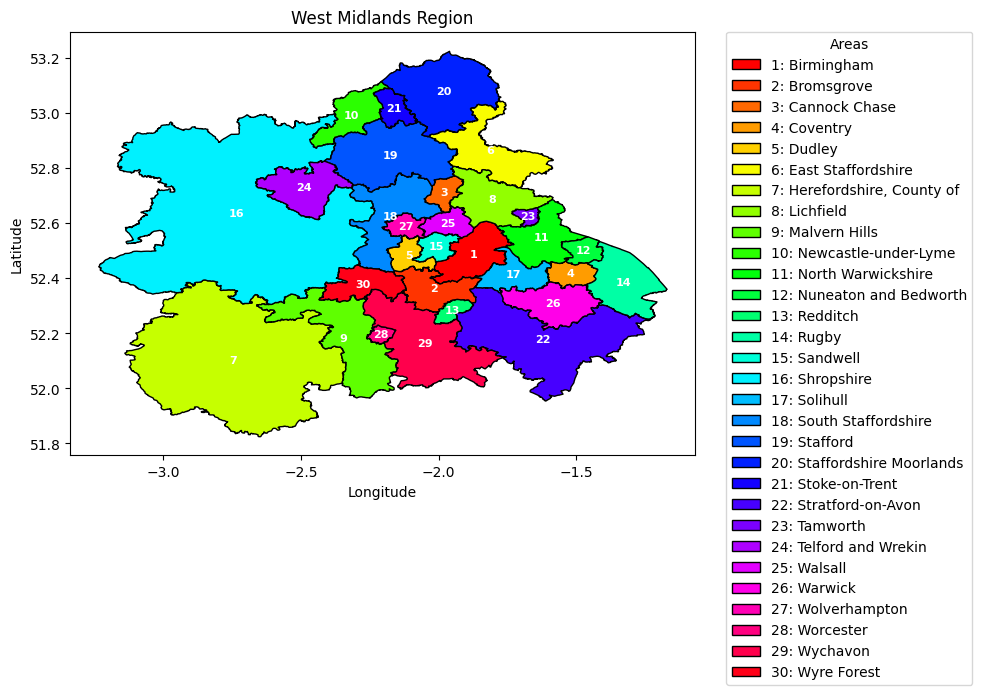

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Reading the CSV file into a DataFrame
topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv'
topo_lad_df = pd.read_csv(topo_lad_csv_path)

# Converting the DataFrame to a GeoDataFrame
topo_lad_gdf = gpd.GeoDataFrame(topo_lad_df, geometry=gpd.GeoSeries.from_wkt(topo_lad_df['geometry']))

# Filtering for the specified areas
areas_to_visualize = [
    "Birmingham", "Bromsgrove", "Cannock Chase", "Coventry", "Dudley",
    "East Staffordshire", "Herefordshire, County of", "Lichfield", "Malvern Hills",
    "Newcastle-under-Lyme", "North Warwickshire", "Nuneaton and Bedworth", "Redditch",
    "Rugby", "Sandwell", "Shropshire", "Solihull", "South Staffordshire",
    "Stafford", "Staffordshire Moorlands", "Stoke-on-Trent", "Stratford-on-Avon",
    "Tamworth", "Telford and Wrekin", "Walsall", "Warwick", "Wolverhampton",
    "Worcester", "Wychavon", "Wyre Forest"
]

# Filtering the GeoDataFrame for the specified areas
filtered_gdf = topo_lad_gdf[topo_lad_gdf['LAD13NM'].isin(areas_to_visualize)]

# Assigning a unique color to each area
colors = plt.cm.get_cmap('hsv', len(areas_to_visualize))

# Plotting each area with a unique color and annotating with a number
fig, ax = plt.subplots(figsize=(10, 10))
legend_elements = []
for i, area in enumerate(areas_to_visualize):
    area_gdf = filtered_gdf[filtered_gdf['LAD13NM'] == area]
    area_gdf.plot(ax=ax, edgecolor='black', facecolor=colors(i))
    pos = area_gdf.geometry.centroid.iloc[0].coords[0]
    ax.annotate(text=str(i+1), xy=pos, horizontalalignment='center', verticalalignment='center', fontsize=8, weight='bold', color='white')
    legend_elements.append(Patch(facecolor=colors(i), edgecolor='black', label=f'{i+1}: {area}'))

# Setting the title and labels
ax.set_title('West Midlands Region')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Creating the legend outside the plot on the left
plt.legend(handles=legend_elements, title="Areas", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

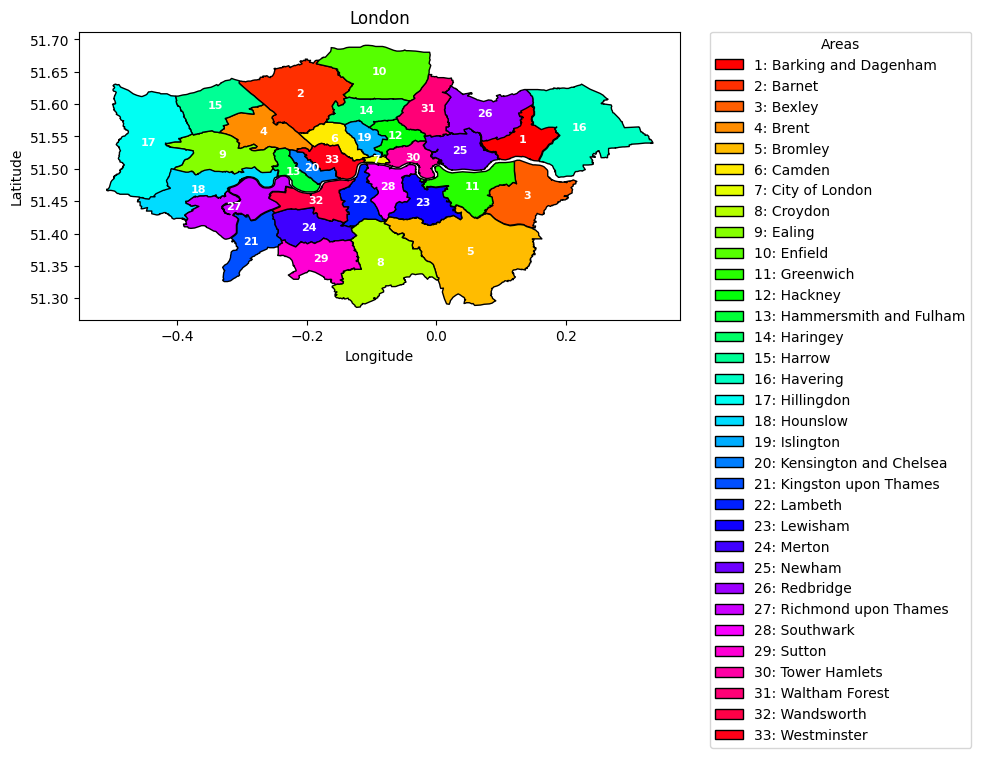

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Reading the CSV file into a DataFrame
topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv'
topo_lad_df = pd.read_csv(topo_lad_csv_path)

# Converting the DataFrame to a GeoDataFrame
topo_lad_gdf = gpd.GeoDataFrame(topo_lad_df, geometry=gpd.GeoSeries.from_wkt(topo_lad_df['geometry']))

# Filtering for the specified areas
areas_to_visualize = [
        "Barking and Dagenham", "Barnet", "Bexley", "Brent", "Bromley",
        "Camden", "City of London", "Croydon", "Ealing", "Enfield",
        "Greenwich", "Hackney", "Hammersmith and Fulham", "Haringey", "Harrow",
        "Havering", "Hillingdon", "Hounslow", "Islington", "Kensington and Chelsea",
        "Kingston upon Thames", "Lambeth", "Lewisham", "Merton", "Newham",
        "Redbridge", "Richmond upon Thames", "Southwark", "Sutton", "Tower Hamlets",
        "Waltham Forest", "Wandsworth", "Westminster"
    ]

# Filtering the GeoDataFrame for the specified areas
filtered_gdf = topo_lad_gdf[topo_lad_gdf['LAD13NM'].isin(areas_to_visualize)]

# Assigning a unique color to each area
colors = plt.cm.get_cmap('hsv', len(areas_to_visualize))

# Plotting each area with a unique color and annotating with a number
fig, ax = plt.subplots(figsize=(10, 10))
legend_elements = []
for i, area in enumerate(areas_to_visualize):
    area_gdf = filtered_gdf[filtered_gdf['LAD13NM'] == area]
    area_gdf.plot(ax=ax, edgecolor='black', facecolor=colors(i))
    pos = area_gdf.geometry.centroid.iloc[0].coords[0]
    ax.annotate(text=str(i+1), xy=pos, horizontalalignment='center', verticalalignment='center', fontsize=8, weight='bold', color='white')
    legend_elements.append(Patch(facecolor=colors(i), edgecolor='black', label=f'{i+1}: {area}'))

# Setting the title and labels
ax.set_title('London')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Creating the legend outside the plot on the left
plt.legend(handles=legend_elements, title="Areas", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

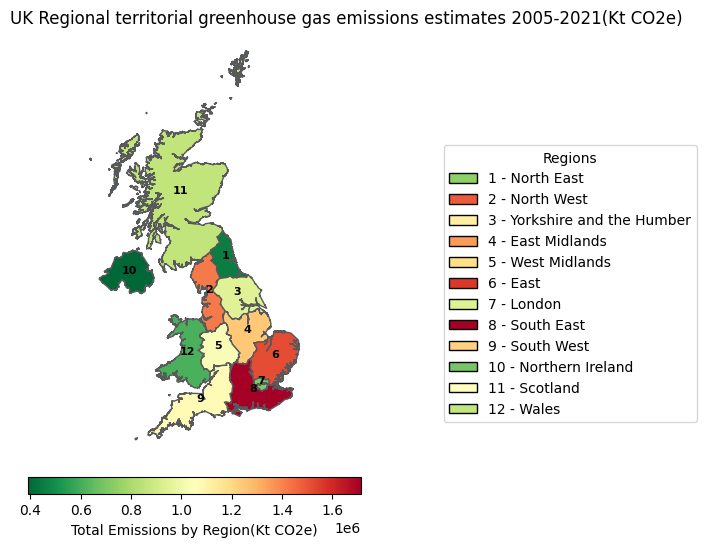

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

file_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/uk_regions.geojson'

uk_regions_gdf = gpd.read_file(file_path)

emissions_data = {
    "Region/Country": [
        "East Midlands", "East of England", "London", "North East", "North West",
        "Northern Ireland", "Scotland", "South East", "South West", "Wales",
        "West Midlands", "Yorkshire and the Humber"
    ],
    "Grand Total": [
        1.246579e+06, 1.518514e+06, 7.105470e+05, 4.513099e+05, 1.419484e+06,
        3.910081e+05, 8.602071e+05, 1.713013e+06, 1.073928e+06, 6.104329e+05,
        1.030287e+06, 9.443414e+05
    ]
}

#emissions_df = regional_emissions.reset_index()
#emissions_df.columns = ['Region/Country', 'Grand Total']

emissions_df = pd.DataFrame(emissions_data)
emissions_df['Region/Country'] = emissions_df['Region/Country'].replace({'East of England': 'East'})

uk_regions_with_emissions = uk_regions_gdf.merge(emissions_df, left_on='rgn19nm', right_on='Region/Country', how='left')

uk_regions_with_emissions['Number'] = range(1, len(uk_regions_with_emissions) + 1)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
uk_regions_with_emissions.plot(column='Grand Total', ax=ax, cmap='RdYlGn_r', edgecolor='#58595B')

cmap = plt.cm.RdYlGn_r
norm = mcolors.Normalize(vmin=uk_regions_with_emissions['Grand Total'].min(), vmax=uk_regions_with_emissions['Grand Total'].max())

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.036, pad=0.04)
cbar.set_label('Total Emissions by Region(Kt CO2e)')

for idx, row in uk_regions_with_emissions.iterrows():
    plt.annotate(text=str(row['Number']), xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontweight='bold', color='black', fontsize=8)

legend_elements = [Patch(facecolor=plt.cm.RdYlGn_r(emission / uk_regions_with_emissions['Grand Total'].max()), edgecolor='black',
                         label=f"{number} - {region}") for number, region, emission in zip(uk_regions_with_emissions['Number'],
                         uk_regions_with_emissions['rgn19nm'], uk_regions_with_emissions['Grand Total'])]

ax.legend(handles=legend_elements, title="Regions", bbox_to_anchor=(1.55, 0.75), loc='upper left')

ax.set_title('UK Regional territorial greenhouse gas emissions estimates 2005-2021(Kt CO2e)', loc='left', position=(-0.3, 1))
plt.axis('off')
plt.show()


<h1>Network Science</h1>

In [ ]:
pip install --upgrade networkx matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 46.2 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


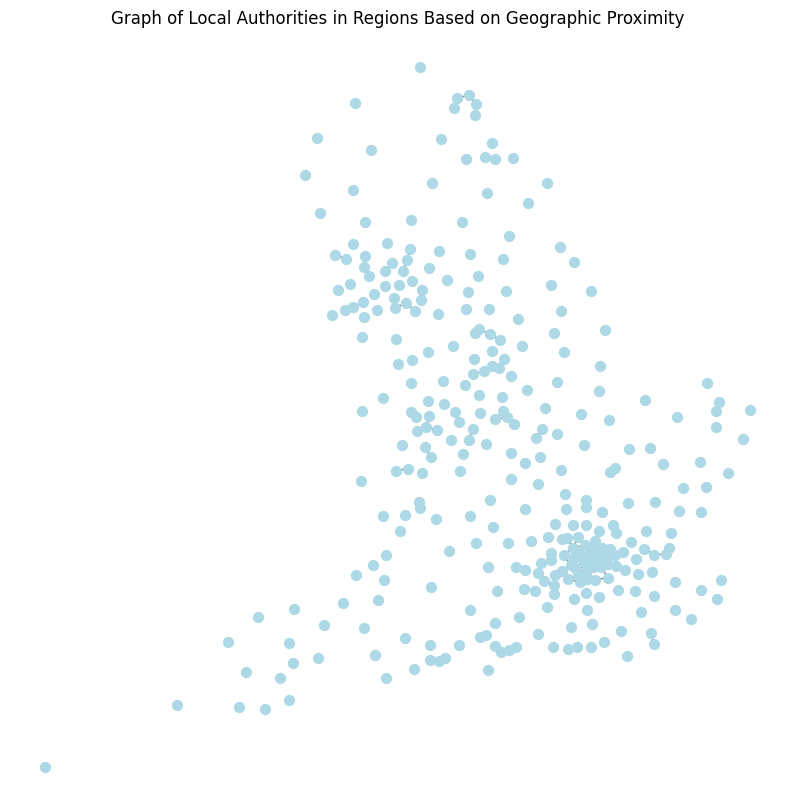

In [ ]:
import pandas as pd

# Load the datasets
topo_lad_df = pd.read_csv('https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv')
all_regions_data_ = pd.read_csv('https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/all_regions_data_.csv')

# Merge on the 'Local Authority' column to align the datasets
filtered_gdf_ = all_regions_data_.merge(topo_lad_df, left_on='Local Authority', right_on='LAD13NM')

import geopandas as gpd
from shapely import wkt

# Convert 'geometry' column from WKT to shapely geometries
topo_lad_df['geometry'] = topo_lad_df['geometry'].apply(wkt.loads)

# Convert the pandas DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(topo_lad_df, geometry='geometry')

# Calculate centroids
gdf['centroid'] = gdf['geometry'].centroid

# Extract latitude and longitude from the centroids
gdf['latitude'] = gdf['centroid'].y
gdf['longitude'] = gdf['centroid'].x

import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0
    # Convert coordinates from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Compute differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Haversine formula
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    return distance

def find_neighbors(gdf, threshold=10):  # Threshold in kilometers
    edges = []
    for index, row in gdf.iterrows():
        lat1, lon1 = row['latitude'], row['longitude']
        for j, candidate_row in gdf.iterrows():
            if index == j:
                continue  # Skip self
            lat2, lon2 = candidate_row['latitude'], candidate_row['longitude']
            distance = haversine(lat1, lon1, lat2, lon2)
            if distance <= threshold:
                edges.append((index, j))
    return edges


edges = find_neighbors(gdf, threshold=10)

import networkx as nx

# Initialize an empty graph
G = nx.Graph()

G.add_edges_from(edges)

for index, row in gdf.iterrows():
    G.add_node(index, label=row['LAD13NM'])

import matplotlib.pyplot as plt

# Define positions based on geographic coordinates
pos = {index: (row['longitude'], row['latitude']) for index, row in gdf.iterrows()}

# Draw the graph
fig, ax = plt.subplots(figsize=(10, 10))
#nx.draw(G, pos, with_labels=False, node_size=50, node_color='lightblue', edge_color='gray', width=1)
nx.draw(G, pos, ax=ax, with_labels=False, node_size=50, node_color='lightblue', edge_color='gray', width=1)
plt.title('Graph of Local Authorities in Regions Based on Geographic Proximity')
plt.show()


<h2>Centrality</h2>

In [ ]:

degree_centrality = nx.degree_centrality(G)

sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)

betweenness_centrality = nx.betweenness_centrality(G)

sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)

print("Top 5 nodes by degree centrality:")
for node, centrality in sorted_degree_centrality[:5]:
    print(f"Node {node}: {centrality}")

print("\nTop 5 nodes by betweenness centrality:")
for node, centrality in sorted_betweenness_centrality[:5]:
    print(f"Node {node}: {centrality}")




Top 5 nodes by degree centrality:
Node 293: 0.04
Node 320: 0.03692307692307692
Node 322: 0.03692307692307692
Node 325: 0.03692307692307692
Node 299: 0.033846153846153845

Top 5 nodes by betweenness centrality:
Node 230: 0.006190589246144802
Node 229: 0.005451092117758785
Node 310: 0.004997562073232572
Node 234: 0.004881291547958215
Node 301: 0.003865628645626077


<h2>Community Detection</h2>

In [ ]:

from networkx.algorithms import community

communities_generator = community.girvan_newman(G)

top_level_communities = next(communities_generator)

communities = sorted(map(sorted, top_level_communities))

for i, community in enumerate(communities):
    print(f"Community {i}: {community}")


Community 0: [0]
Community 1: [1, 3]
Community 2: [2]
Community 3: [4]
Community 4: [5]
Community 5: [6]
Community 6: [7, 148]
Community 7: [8, 147]
Community 8: [9]
Community 9: [10]
Community 10: [11]
Community 11: [12]
Community 12: [13]
Community 13: [14, 17, 75, 194, 195]
Community 14: [15, 157, 159, 163]
Community 15: [16]
Community 16: [18]
Community 17: [19]
Community 18: [20]
Community 19: [21]
Community 20: [22]
Community 21: [23]
Community 22: [24]
Community 23: [25]
Community 24: [26]
Community 25: [27, 28, 87]
Community 26: [29]
Community 27: [30]
Community 28: [31]
Community 29: [32, 98, 101, 107]
Community 30: [33]
Community 31: [34]
Community 32: [35, 38, 39, 58, 226, 229, 231, 234]
Community 33: [36]
Community 34: [37, 40]
Community 35: [41]
Community 36: [42]
Community 37: [43, 119, 120, 122]
Community 38: [44, 118]
Community 39: [45]
Community 40: [46]
Community 41: [47]
Community 42: [48]
Community 43: [49]
Community 44: [50]
Community 45: [51]
Community 46: [52]
Co

In [1]:
pip install python-louvain

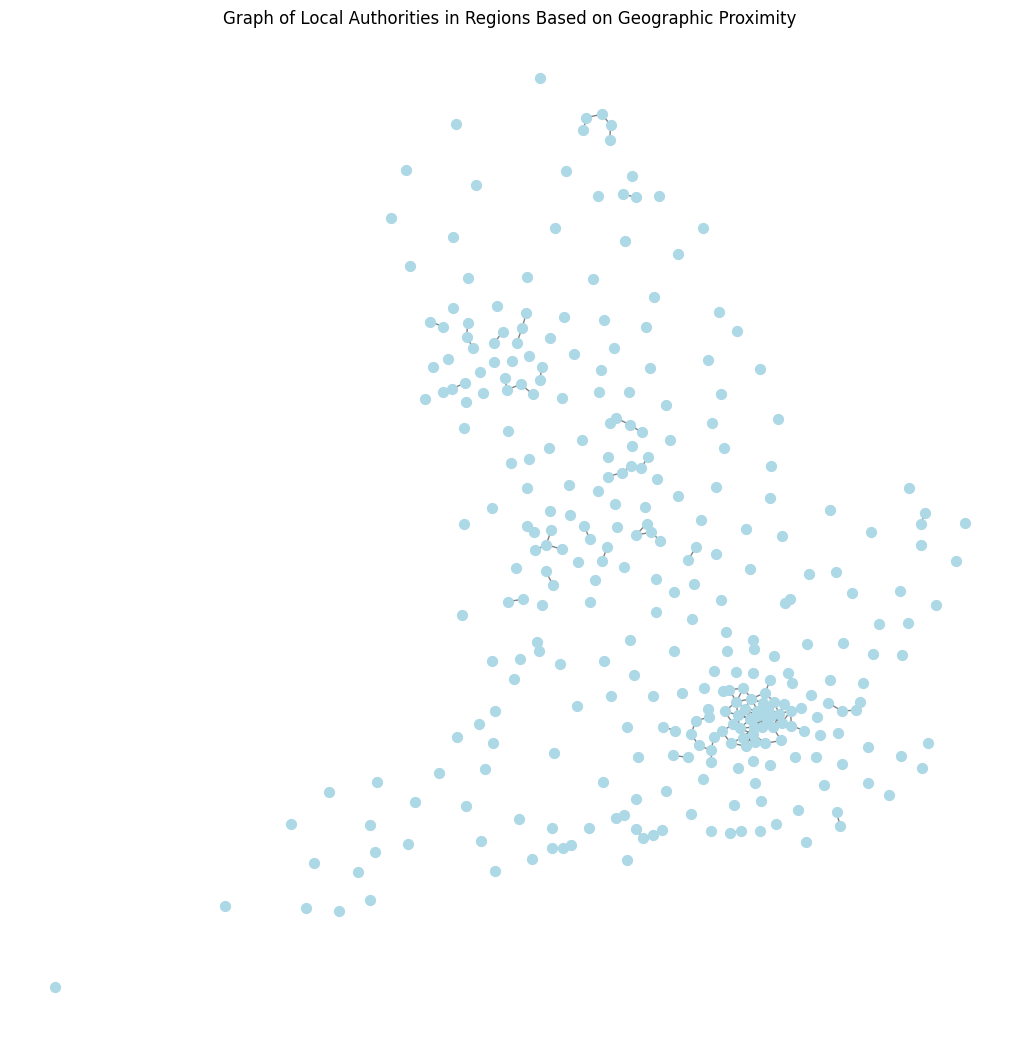

In [6]:
import pandas as pd

# Load the datasets
topo_lad_df = pd.read_csv('https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv')
all_regions_data_ = pd.read_csv('https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/all_regions_data_.csv')

# Merge on the 'Local Authority' column to align the datasets
filtered_gdf_ = all_regions_data_.merge(topo_lad_df, left_on='Local Authority', right_on='LAD13NM')

import geopandas as gpd
from shapely import wkt

# Convert 'geometry' column from WKT to shapely geometries
topo_lad_df['geometry'] = topo_lad_df['geometry'].apply(wkt.loads)

# Convert the pandas DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(topo_lad_df, geometry='geometry')

# Calculate centroids
gdf['centroid'] = gdf['geometry'].centroid

# Extract latitude and longitude from the centroids
gdf['latitude'] = gdf['centroid'].y
gdf['longitude'] = gdf['centroid'].x

import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0
    # Convert coordinates from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Compute differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Haversine formula
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    return distance

def find_neighbors(gdf, threshold=10):  # Threshold in kilometers
    edges = []
    for index, row in gdf.iterrows():
        lat1, lon1 = row['latitude'], row['longitude']
        for j, candidate_row in gdf.iterrows():
            if index == j:
                continue  # Skip self
            lat2, lon2 = candidate_row['latitude'], candidate_row['longitude']
            distance = haversine(lat1, lon1, lat2, lon2)
            if distance <= threshold:
                edges.append((index, j))
    return edges


edges = find_neighbors(gdf, threshold=10)

import networkx as nx

# Initialize an empty graph
G = nx.Graph()

G.add_edges_from(edges)

for index, row in gdf.iterrows():
    G.add_node(index, label=row['LAD13NM'])

import matplotlib.pyplot as plt

# Define positions based on geographic coordinates
pos = {index: (row['longitude'], row['latitude']) for index, row in gdf.iterrows()}

# Draw the graph
plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=False, node_size=50, node_color='lightblue', edge_color='gray', width=1)
plt.title('Graph of Local Authorities in Regions Based on Geographic Proximity')
plt.show()


In [2]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Load the geographic dataset
topo_lad_df = pd.read_csv('https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv')

# Convert 'geometry' column from WKT to shapely geometries
topo_lad_df['geometry'] = topo_lad_df['geometry'].apply(wkt.loads)

# Convert the pandas DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(topo_lad_df, geometry='geometry')

# Calculate centroids
gdf['centroid'] = gdf['geometry'].centroid

# Extract latitude and longitude from the centroids
gdf['latitude'] = gdf['centroid'].y
gdf['longitude'] = gdf['centroid'].x


In [8]:


#import community as community_louvain
import networkx as nx
from community.community_louvain import best_partition
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import plotly.graph_objects as go


# Now, use the best_partition function directly
partition = best_partition(G)

# Create a colormap
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)

fig = go.Figure()

# Add nodes to the map, colored by their community
for index, (node, community) in enumerate(partition.items()):
    row = gdf.iloc[node]
    fig.add_trace(go.Scattermapbox(
        lat=[row['latitude']],
        lon=[row['longitude']],
        mode='markers',
        marker=go.scattermapbox.Marker(size=9, color=cmap(community)),
        text=row['LAD13NM'],  # Adjust if using a different label
        hoverinfo='text'
    ))

# Add edges to the map (optional, as it might clutter the map)
# [Your existing code to add edges]

# Update the layout of the map (reuse your existing map settings)
fig.update_layout(
    mapbox=dict(
        accesstoken='pk.eyJ1Ijoib2xhamlkZWZlbWkiLCJhIjoiY2xzaXkybDBxMHF5dTJscG5nMzh6aW1udCJ9.RhwlWVHMNI3H1TtUtX6iYQ',
        zoom=5,
        center=dict(
            lat=gdf['latitude'].mean(),
            lon=gdf['longitude'].mean()
        ),
        style='mapbox://styles/mapbox/light-v10'
    ),
    showlegend=False,
    margin=dict(l=0, r=0, t=0, b=0)
)

# Show the figure
fig.show()


<ipython-input-8-006d8cedd9ca>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
